# **Intro**

## M1
This is the original model structure (M1)
This is almost identical to "[DIVA: DOMAIN INVARIANT VARIATIONAL AUTOENCODERS](https://arxiv.org/pdf/1905.10427.pdf)".
To breifly describe the model, we have 3 independent encoders that encode for different sources of variation: cell-type proportion, sample-id, and everything else (slack).
To enforce this disentanglement, there are classification losses on the cell-type and smaple_id embeddings.
The embeddings are then concatenated together and used as input to a joint decoder.
When used in the semi-supervised mode, the classification loss is calculated by comparing the classifier output to the latent digit representation.
The model is depicted below.

## M2
This is the updated model structure (M2)
This model directly inserts the cell type proportions as a section of the latent code when available and simultaneously trains a cell-type proportion predictor. When the cell-type proportions are not available, the proportion predictor is used to generate the relevant section in the latent code.

The model is depicted below.

## Training
We flip between M1 and M2 during training.
This is to get the best of both worlds.
M1 uses all the data to get a good latent representation, that is hopefully predictive of the cell type proportions.
M2 takes better advantage of the labeled data.
One would think that using both makes for a better results, but this is harder to train -- no clear results and bad performance.

## Experiment
The experimental set-up is as follows:
All data is from pbmc6k dataset.
Cells are sampled to generate 10 pesudobulks.
There are perturbed samples --> this means that for some samples we have mono14 cells instead of mono16 cells. 
This is like a perturbation that would cause one cell type to change.
We use 2 samples as the labeled data (meaning each sample has a ground truth) and 8 samples with unlabeled data (ground truth proportions are not used in training.)


This code was based off of DIVA's codebase: https://github.com/AMLab-Amsterdam/DIVA

Semi-supervised training method was take from here:
And this tutorial: https://github.com/bjlkeng/sandbox/tree/master/notebooks/vae-semi_supervised_learning with an awesome accomanying blogpost: https://bjlkeng.github.io/posts/semi-supervised-learning-with-variational-autoencoders/

Another codebase referenced: https://github.com/saemundsson/semisupervised_vae


# M1

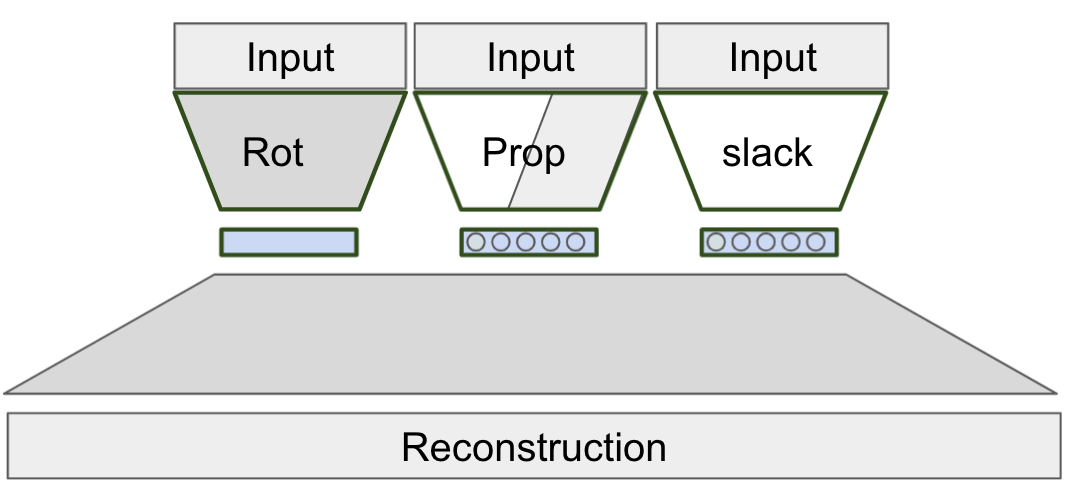


# M2
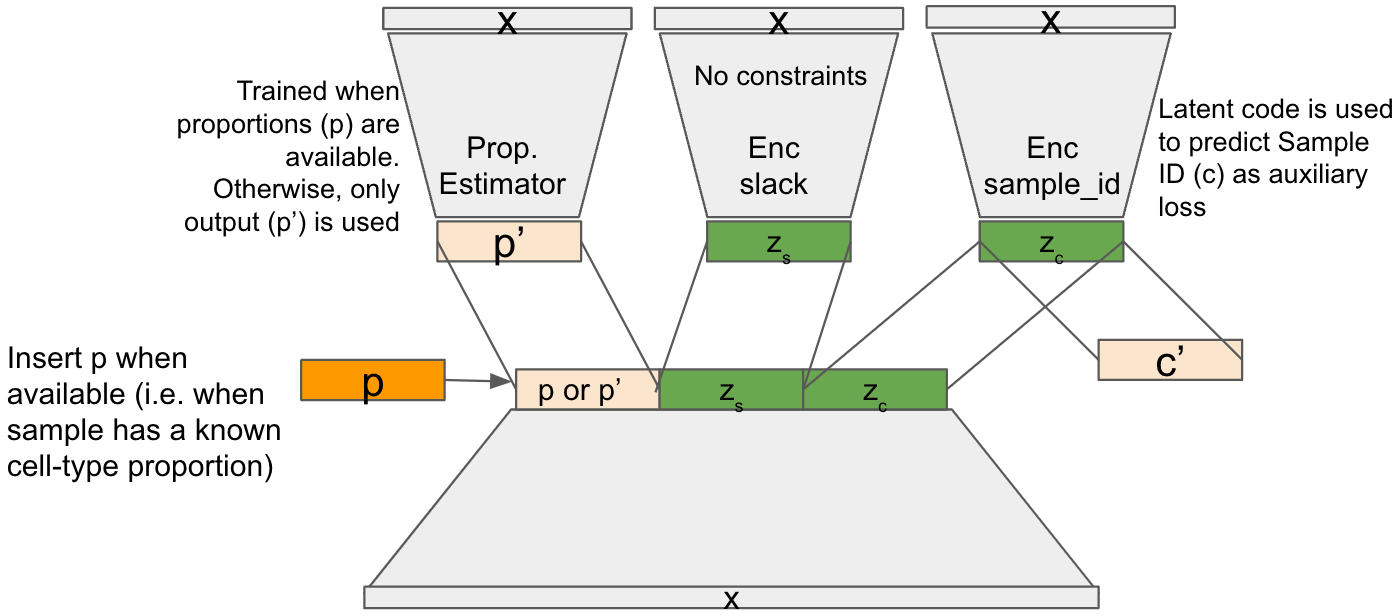

# **Imports**

In [34]:
# general imports
import warnings
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Softmax, ReLU, ELU, LeakyReLU
from keras.layers.merge import concatenate as concat
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mean_absolute_error, mean_squared_error, KLDivergence
from tensorflow.keras.datasets import mnist
from tensorflow.keras.activations import relu, linear
from tensorflow.keras.utils import to_categorical, normalize, plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from scipy.stats import spearmanr, pearsonr
from scipy.spatial.distance import euclidean
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from PIL import Image

from tqdm import tnrange, tqdm_notebook
import ipywidgets

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

# programming stuff
import time
import os
import pickle
from pathlib import Path

# import the SC_preprocessing code
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
from sc_preprocessing import sc_preprocess


# disable eager execution
# https://github.com/tensorflow/tensorflow/issues/47311#issuecomment-786116401
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()


In [35]:
## parameters
aug_data_path = f"{os.getcwd()}/../data/single_cell_data/augmented_pbmc_data/"
res_data_path = f"{os.getcwd()}/../results/single_cell_data/diva_pbmc/"
num_genes = 1000

exp_id = "pbmc6k-mono"

# Set-up experimental variables

In [36]:

##################################################
#####. set up experiment specific variables
##################################################

#if args.exp_id != "pbmc68k":
#    sys.exit("Error, exp_id not currently supported")
        
# number expected cell types
n_cell_types = 7

# number of patients/domains/samples expected
idx_range_lab = range(0, 10)
#idx_range_unlab = range(0, 10)
n_tot_samples = 10

# number of drugs (one-hot encoded)
n_drugs = 2

# experiment id
lab_file_name = exp_id
#unlab_file_name = args.unlab_exp_id

# number of pseudobulks PER patient
n_train = 1000



### create the domains label 
Label_full = np.concatenate([np.full(n_train, 0), np.full(n_train, 1),
                            np.full(n_train, 2), np.full(n_train, 3),
                            np.full(n_train, 4), np.full(n_train, 5),
                            np.full(n_train, 6), np.full(n_train, 7),
                            np.full(n_train, 8), np.full(n_train, 9)], axis=0)
label_full = to_categorical(Label_full)

### create the drugs label 
Drug_full = np.concatenate([np.full(n_train, 1), np.full(n_train, 0),
                            np.full(n_train, 0), np.full(n_train, 0),
                            np.full(n_train, 0), np.full(n_train, 1),
                            np.full(n_train, 1), np.full(n_train, 1),
                            np.full(n_train, 0), np.full(n_train, 0)], axis=0)
drug_full = to_categorical(Drug_full)

# indexes for the training
# 1-9 is labeled training
# 11-19 is unlabeled
# 10 is held out to test
# 0 is held out
#idx_train = np.where(np.logical_and(Label_full>0, Label_full!=3))[0]
#idx_unlab = np.where(Label_full == 3)[0]
#idx_0 = np.where(Label_full==0)[0]

idx_train = np.where(np.logical_and(Label_full > 0, Label_full < 5))[0]
idx_unlab = np.where(Label_full > 5)[0]
idx_drug = np.where(Drug_full > 0)[0]
idx_5 = np.where(Label_full == 5)[0]
idx_0 = np.where(Label_full==0)[0]

idx_train = np.where(np.logical_and(Label_full > -1, Label_full < 2))[0]
idx_unlab = np.where(Label_full >= 2)[0]
idx_drug = np.where(Drug_full > 0)[0]
idx_5 = np.where(Label_full == 5)[0]
idx_0 = np.where(Label_full==0)[0]



# **Load / Pre-process data**
Import pre-processed pseudobulks

In [37]:

##################################################
#####. Design the experiment
##################################################

# read in the labeled data
X_train, Y_train, gene_df = sc_preprocess.read_all_diva_files(aug_data_path, idx_range_lab, lab_file_name)
X_train.columns = gene_df

# only get genes that are available in both testing and training
common_genes_file = os.path.join(aug_data_path, "intersection_genes.pkl")
gene_out_path = Path(common_genes_file)
common_genes = pickle.load(open( gene_out_path, "rb" ))

# try using the cibersort genes
cibersort_file_path = f"{os.getcwd()}/../results/single_cell_data/cibersort_pbmc/CIBERSORTx_Job8_pbmc6k-mono_0_cybersort_sig_inferred_phenoclasses.CIBERSORTx_Job8_pbmc6k-mono_0_cybersort_sig_inferred_refsample.bm.K999.txt"
cibersort_df = pd.read_csv(cibersort_file_path, sep="\t" )
cibersort_genes = cibersort_df["NAME"].values.tolist()

common_genes = np.union1d(common_genes, cibersort_genes)
X_train = X_train[common_genes]
X_train.head()

gene_df = gene_df.loc[gene_df.isin(common_genes)]


# convert to data matrices
X_full = X_train.to_numpy()
Y_full = Y_train.to_numpy()

## get the top variable genes
X_colmean = X_full.mean(axis=0)
#X_colvar = X_full.var(axis=0)
#X_CoV = np.array(np.divide(X_colvar, X_colmean+0.001))
#idx_top = np.argpartition(X_CoV, -num_genes)[-num_genes:]
#gene_df = gene_df.iloc[idx_top]

X_full = X_train.loc[:,cibersort_genes]
X_full = X_full.to_numpy()

## normalize within sample
X_full = scale(X_full, axis=1)
            
print(X_full.shape)

print(np.where(X_colmean == 0)[0].tolist())



# for unknown proportions; i.e. 3 
X_unkp = X_full[idx_unlab,]
label_unkp = label_full[idx_unlab,]
drug_unkp = drug_full[idx_unlab,]
y_unkp = Y_full[idx_unlab,]

# for known proportions
X_kp = X_full[idx_train,]
label_kp = label_full[idx_train,]
drug_kp = drug_full[idx_train,]
y_kp = Y_full[idx_train,]


# test
X_0 = X_full[idx_0,]
label_0 = label_full[idx_0,]
drug_0 = drug_full[idx_0,]
y_0 = Y_full[idx_0,]


(10000, 1540)
[]


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.009s...
[t-SNE] Computed neighbors for 10000 samples in 3.603s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 3.701865
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.180016
[t-SNE] KL divergence after 300 iterations: 2.070817
(10000, 2)
(10000, 2)


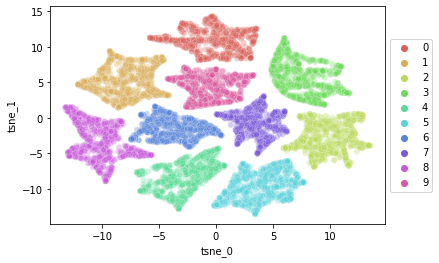

In [38]:
## plot samples
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_full)

plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
plot_df['augmentation'] = Label_full

g = sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="augmentation",
    palette=sns.color_palette("hls", n_tot_samples),
    legend="full",
    alpha=0.3
)
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))


# **M1 Model Definition**

# **Model Definition**


## Hyperparameters

In [39]:

##################################################
#####. Hyperparameters
##################################################

batch_size = 500
n_epoch = 500 # 100 

alpha_rot = 1000000
#alpha_class = 100
alpha_prop = 100 #100
alpha_drug = 1000000

beta_kl_slack = 10
beta_kl_rot = 100
beta_kl_prop = 10
beta_kl_drug = 1000


n_x = X_full.shape[1]
n_y = Y_full.shape[1]
n_label = n_tot_samples  # 6 "patients" 1 sample augmented into 6 distinct versions
n_drugs = n_drugs  # number of drugs one-hot encoded
n_label_z = 64  # 64 dimensional representation of rotation


# the network dimensions are 784 > 512 > proportion_dim < 512 < 784
n_z = Y_full.shape[1] # latent space size, one latent dimension PER cell type
encoder_dim = 512 # dim of encoder hidden layer
decoder_dim = 512 # dim of encoder hidden layer
decoder_out_dim = n_x # dim of decoder output layer

# labeled classifier
class_dim1 = 32
class_dim2 = 16


activ = 'relu'
optim = Adam(learning_rate=0.001)

print(f"length of X {n_x} and length of y {n_y} n_label {n_label} and n_drugs {n_drugs}")

length of X 1540 and length of y 7 n_label 10 and n_drugs 2


## Encoder + Y classifier

In [40]:
# declare the Keras tensor we will use as input to the encoder
X = Input(shape=(n_x,))
Y = Input(shape=(n_y,))
label = Input(shape=(n_label,))
props = Input(shape=(n_y,))
z_in = Input(shape=(n_y+n_label_z+n_label_z,))
cls_in = Input(shape=(n_label_z,))

inputs = X

# set up encoder network
# this is an encoder with 512 hidden layer
# Dense is a functor, with given initializations (activation and hidden layer dimension)
# After initialization, the functor is returned and inputs is used as an arguement
encoder_s = Dense(encoder_dim, activation=activ, name="encoder_slack")(inputs)
encoder_p = Dense(encoder_dim, activation=activ, name="encoder_prop")(inputs)
encoder_r = Dense(encoder_dim, activation=activ, name="encoder_rot")(inputs)

# now from the hidden layer, you get the mu and sigma for 
# the latent space

mu_slack = Dense(n_label_z, activation='linear', name = "mu_slack")(encoder_s)
l_sigma_slack = Dense(n_label_z, activation='linear', name = "sigma_slack")(encoder_s)

mu_prop = Dense(n_label_z, activation='linear', name = "mu_prop")(encoder_p)
l_sigma_prop = Dense(n_label_z, activation='linear', name = "sigma_prop")(encoder_p)

mu_rot = Dense(n_label_z, activation='linear', name = "mu_rot")(encoder_r)
l_sigma_rot = Dense(n_label_z, activation='linear', name = "sigma_rot")(encoder_r)



## Latent Space

In [41]:
# now we need the sampler from mu and sigma
def sample_z(args):
    mu, l_sigma, n_z = args
    eps = K.random_normal(shape=(batch_size, n_z), mean=0., stddev=1.)
    return mu + K.exp(l_sigma / 2) * eps


# Sampling latent space
z_slack = Lambda(sample_z, output_shape = (n_label_z, ), name="z_samp_slack")([mu_slack, l_sigma_slack, n_label_z])
z_prop = Lambda(sample_z, output_shape = (n_label_z, ), name="z_samp_prop")([mu_prop, l_sigma_prop, n_label_z])
z_rot = Lambda(sample_z, output_shape = (n_label_z, ), name="z_samp_rot")([mu_rot, l_sigma_rot, n_label_z])


# set up labeled classifier
class_hidden1 = Dense(class_dim1, activation=activ, name = "cls_h1")
class_hidden2 = Dense(class_dim2, activation=activ, name="cls_h2")
class_out = Dense(n_y, activation='softmax', name="cls_out")

classifier_h1 = class_hidden1(z_prop)
classifier_h2 = class_hidden2(classifier_h1)
Y_cls = class_out(classifier_h2)



z_concat_lab = concat([z_slack, Y, z_rot])
z_concat_unlab = concat([z_slack, Y_cls, z_rot])
z_concat_M1 = concat([z_slack, z_prop, z_rot])


## Decoder + Classifiers

In [42]:
def null_f(args):
    return args

###### DECODER
# set up decoder network
# this is a decoder with 512 hidden layer
decoder_hidden = Dense(decoder_dim, activation=activ, name = "decoder_h1")
decoder_hidden_M1 = Dense(decoder_dim, activation=activ, name = "decoder_h1_M1")

# final reconstruction
decoder_out = Dense(decoder_out_dim, activation='sigmoid', name = "decoder_out")
decoder_out_M1 = Dense(decoder_out_dim, activation='sigmoid', name = "decoder_out_M1")


# set up the decoder part that links to the encoder
# labeled decoder
h_lab = decoder_hidden(z_concat_lab)
outputs_lab = decoder_out(h_lab)

# unlabeled decoder
h_unlab = decoder_hidden(z_concat_unlab)
outputs_unlab = decoder_out(h_unlab)

# M1 decoder
h_p_M1 = decoder_hidden_M1(z_concat_M1)
outputs_M1 = decoder_out_M1(h_p_M1)

###### Proportions classifier
# this is the proportions we try to estimate
#prop_h1 = Dense(20, activation=activ, name = "prop_h1")
prop_h1 = ReLU(name = "prop_h1")
prop_h2 = Dense(n_z, activation=linear, name = "prop_h2") ###
prop_softmax = Softmax(name = "mu_prop_pred")
decoder_sigma = Lambda(null_f, name = "l_sigma_prop_pred")

prop_1_out = prop_h1(z_prop)
prop_2_out = prop_h2(prop_1_out)
prop_outputs = prop_softmax(prop_2_out)
sigma_outputs_p = decoder_sigma(l_sigma_rot)


###### Rotations classifier
# this is the rotation we try to estimate
rot_h1 = ReLU(name = "rot_h1")
rot_h2 = Dense(n_label, activation='linear', name = "rot_h2")
rot_softmax = Softmax(name = "mu_rot_pred")
decoder_sigma_r = Lambda(null_f, name = "l_sigma_rot_pred")


rot_1_out = rot_h1(z_rot)
rot_2_out = rot_h2(rot_1_out)
rotation_outputs = rot_softmax(rot_2_out)
sigma_outputs_r = decoder_sigma_r(l_sigma_rot)








## Loss

In [43]:

def vae_loss_M1(y_true, y_pred):
    recon = K.sum(mean_squared_error(y_true, y_pred), axis=-1)
    kl_prop = beta_kl_prop * K.sum(K.exp(l_sigma_prop) + K.square(mu_prop) - 1. - l_sigma_prop, axis=-1)
    kl_rot = beta_kl_rot * K.sum(K.exp(l_sigma_rot) + K.square(mu_rot) - 1. - l_sigma_rot, axis=-1)
    kl_slack = beta_kl_slack * K.sum(K.exp(l_sigma_slack) + K.square(mu_slack) - 1. - l_sigma_slack, axis=-1)
    return recon + kl_prop + kl_rot + kl_slack
    
def vae_loss(y_true, y_pred):
    recon = K.sum(mean_squared_error(y_true, y_pred), axis=-1)
    kl_rot = beta_kl_rot * K.sum(K.exp(l_sigma_rot) + K.square(mu_rot) - 1. - l_sigma_rot, axis=-1)
    kl_slack = beta_kl_slack * K.sum(K.exp(l_sigma_slack) + K.square(mu_slack) - 1. - l_sigma_slack, axis=-1)
    return recon + kl_rot + kl_slack

def vae_loss_unk(y_true, y_pred):
    recon = K.sum(mean_squared_error(y_true, y_pred), axis=-1)
    kl_rot = beta_kl_rot * K.sum(K.exp(l_sigma_rot) + K.square(mu_rot) - 1. - l_sigma_rot, axis=-1)
    kl_slack = beta_kl_slack * K.sum(K.exp(l_sigma_slack) + K.square(mu_slack) - 1. - l_sigma_slack, axis=-1)
    return recon + kl_rot + kl_slack


def recon_loss(y_true, y_pred):
	return K.sum(mean_squared_error(y_true, y_pred), axis=-1)


def prop_loss(y_true, y_pred):
  return K.sum(mean_absolute_error(y_true, y_pred), axis=-1) * alpha_prop


def class_loss(y_true, y_pred):
    recon = K.sum(mean_absolute_error(y_true, y_pred), axis=-1)*alpha_rot
    return recon




## Make the computational graph

In [44]:
# M1 Model
known_prop_vae_M1 = Model(X, [outputs_M1, prop_outputs, rotation_outputs, sigma_outputs_p])
unknown_prop_vae_M1 = Model(X, [outputs_M1, rotation_outputs])

known_prop_vae_M1.compile(optimizer=optim, loss=[vae_loss_M1, prop_loss, class_loss, None])
unknown_prop_vae_M1.compile(optimizer=optim, loss=[vae_loss_M1, class_loss])

encoder = Model(X, [z_slack, mu_slack, l_sigma_slack, mu_prop, l_sigma_prop, prop_outputs, z_rot, mu_rot, l_sigma_rot])



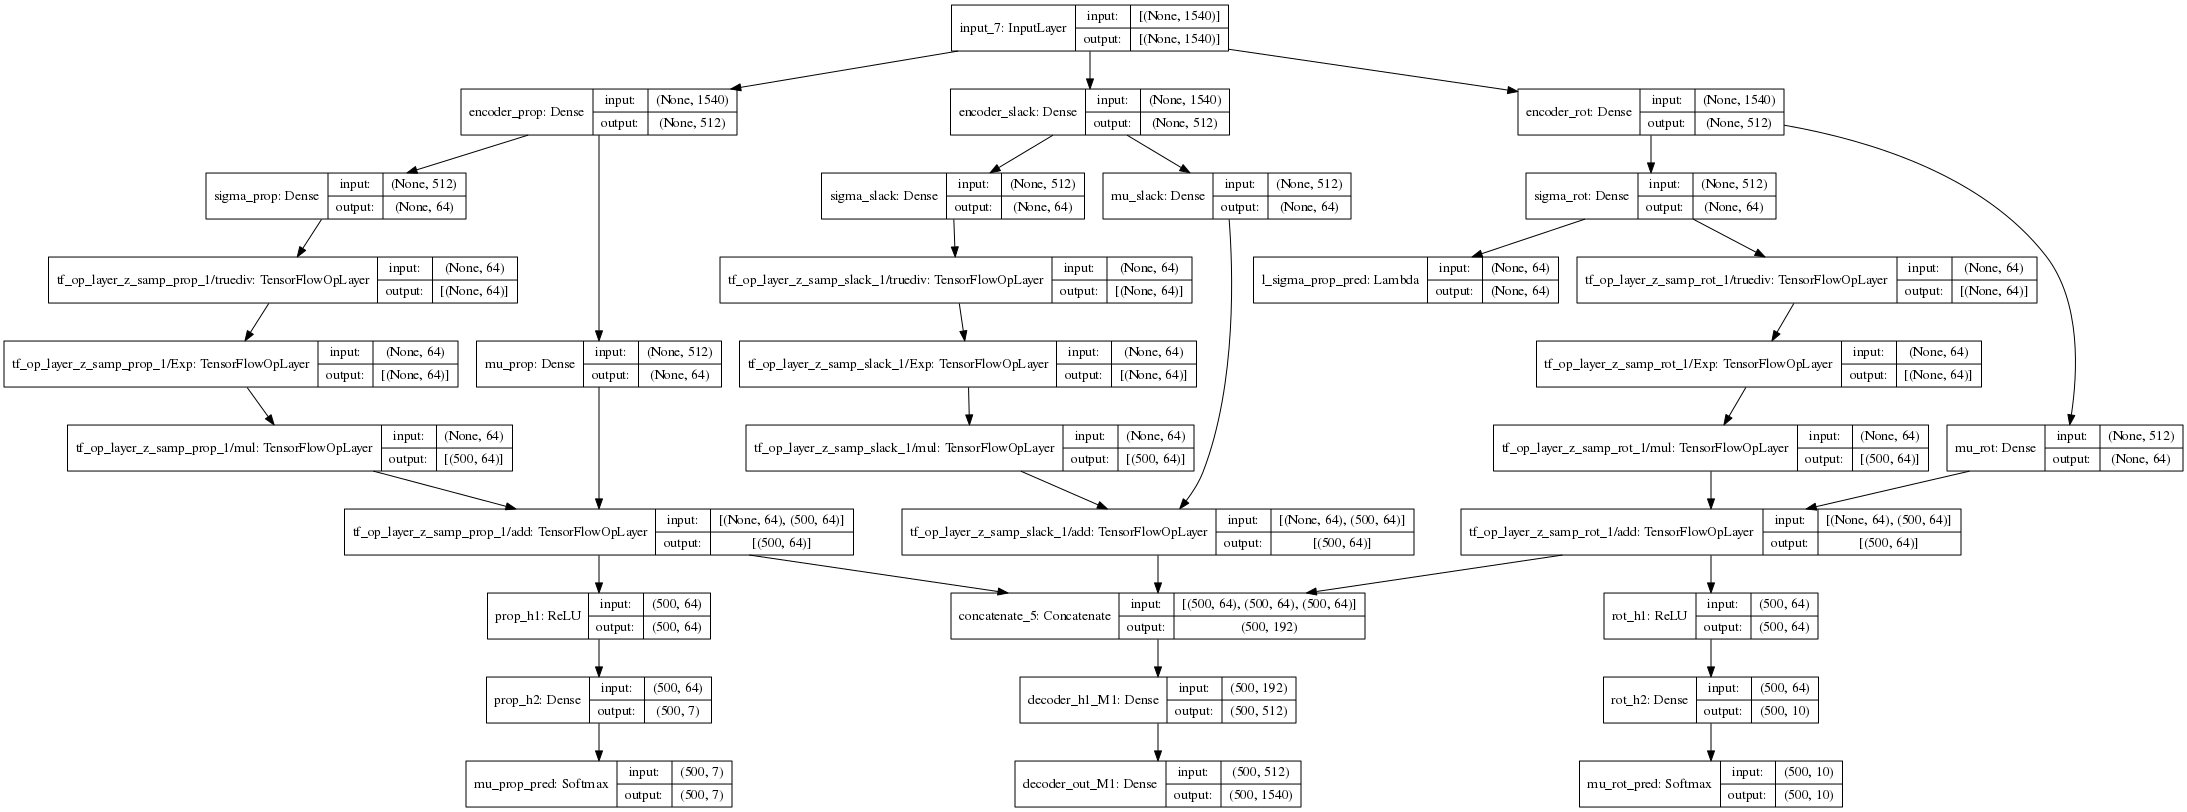

In [45]:
display(plot_model(known_prop_vae_M1, show_layer_names=True, show_shapes=True, dpi=72))

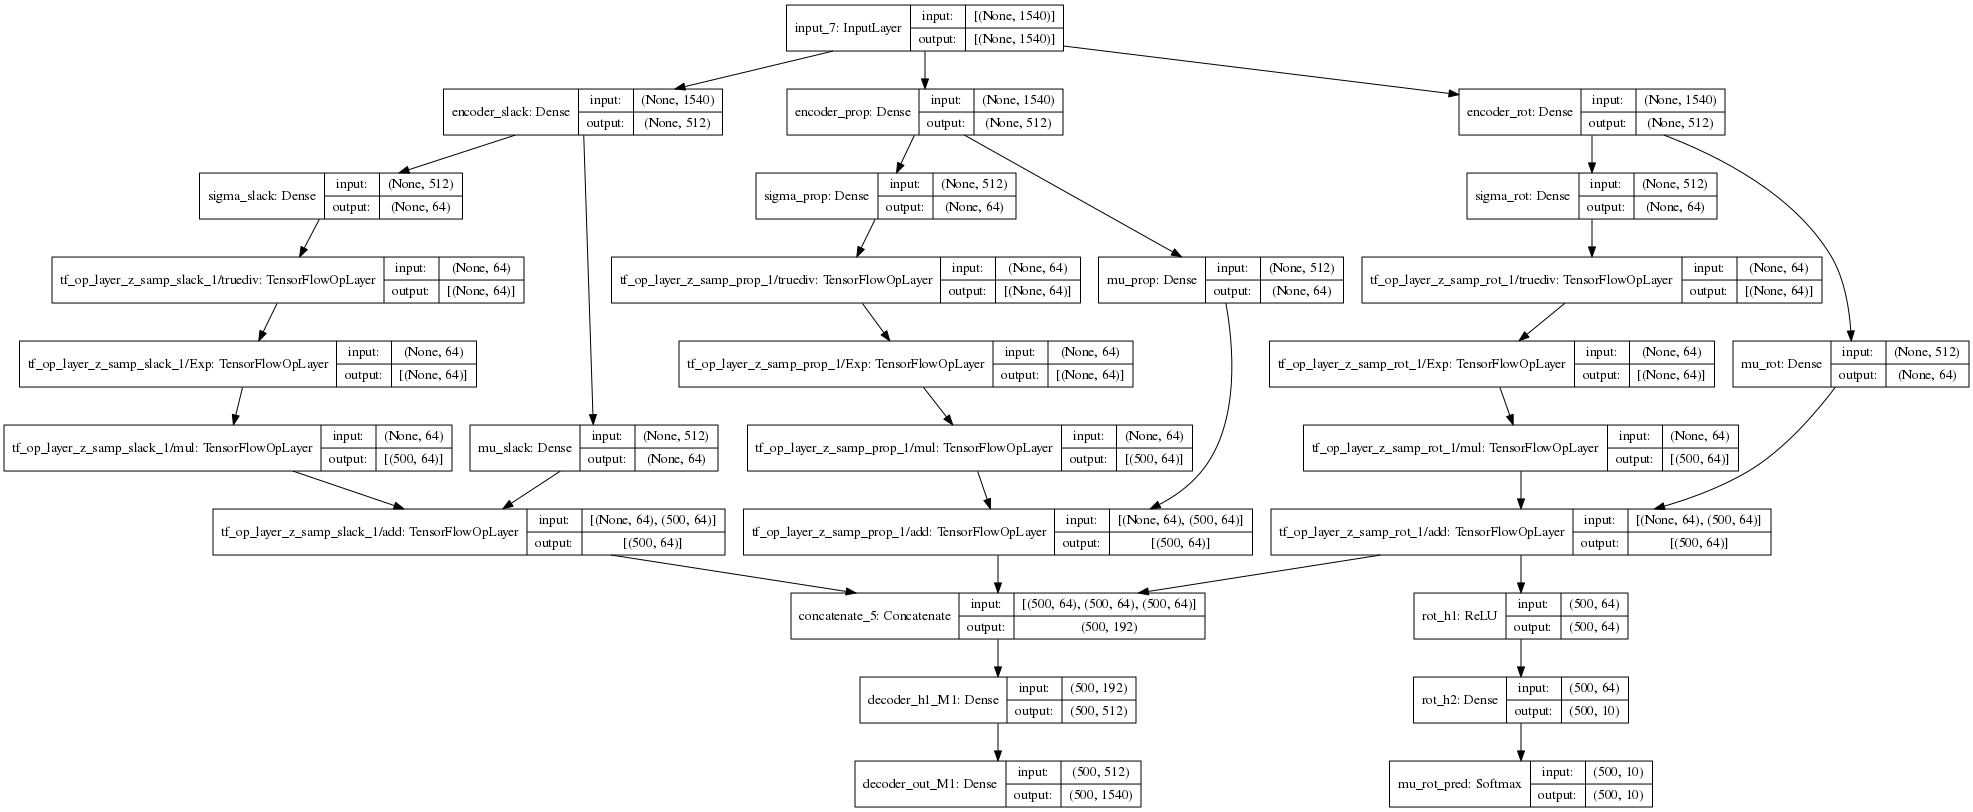

In [46]:
display(plot_model(unknown_prop_vae_M1, show_layer_names=True, show_shapes=True, dpi=72))

In [47]:


# M2 Model

classifier = Model(X, Y_cls)

known_prop_vae = Model([X, Y], [outputs_lab, Y_cls, rotation_outputs])
unknown_prop_vae = Model(X, [outputs_unlab, rotation_outputs])

known_prop_vae.compile(optimizer=optim, loss=[vae_loss_M1, prop_loss, class_loss]) #, metrics = [KL_loss, recon_loss])
unknown_prop_vae.compile(optimizer=optim, loss=[vae_loss_M1, class_loss]) #, metrics = [KL_loss, recon_loss])

encoder_unlab = Model(X, [z_slack, mu_slack, l_sigma_slack, z_rot, mu_rot, l_sigma_rot])

encoder_lab = Model([X, Y], [z_slack, mu_slack, l_sigma_slack, z_rot, mu_rot, l_sigma_rot])




print(known_prop_vae.summary())
print(unknown_prop_vae.summary())


Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 1540)]       0                                            
__________________________________________________________________________________________________
encoder_slack (Dense)           (None, 512)          788992      input_7[0][0]                    
__________________________________________________________________________________________________
encoder_rot (Dense)             (None, 512)          788992      input_7[0][0]                    
__________________________________________________________________________________________________
encoder_prop (Dense)            (None, 512)          788992      input_7[0][0]                    
___________________________________________________________________________________________

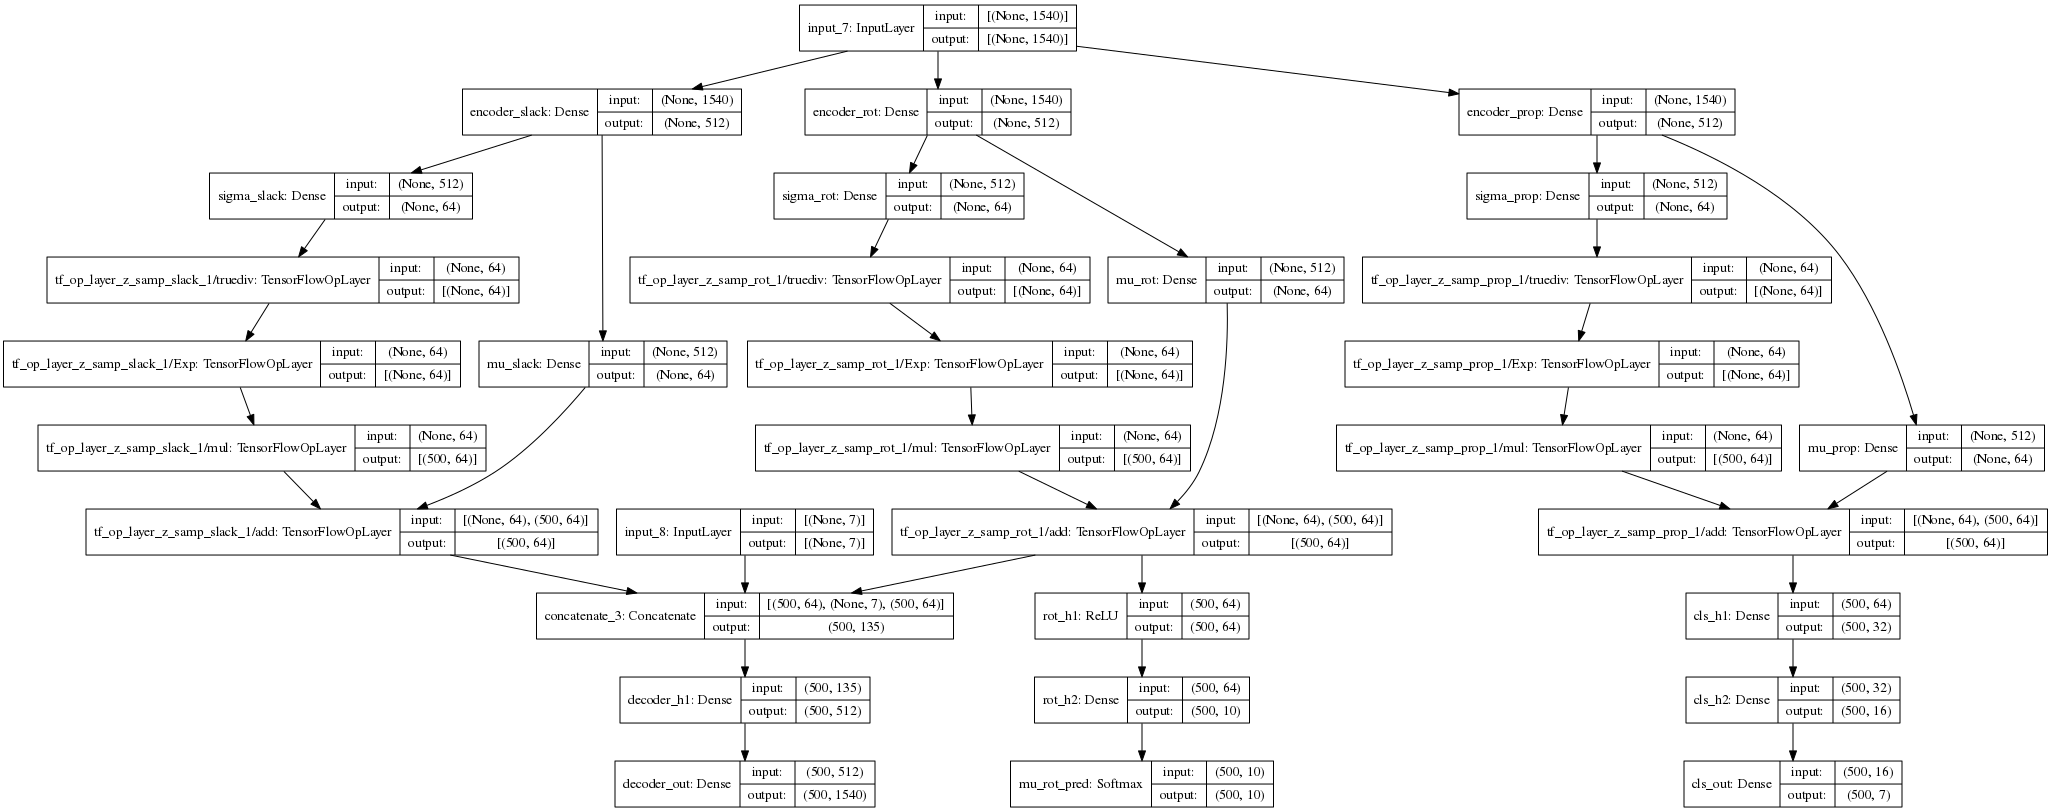

In [48]:
display(plot_model(known_prop_vae, show_layer_names=True, show_shapes=True, dpi=72))

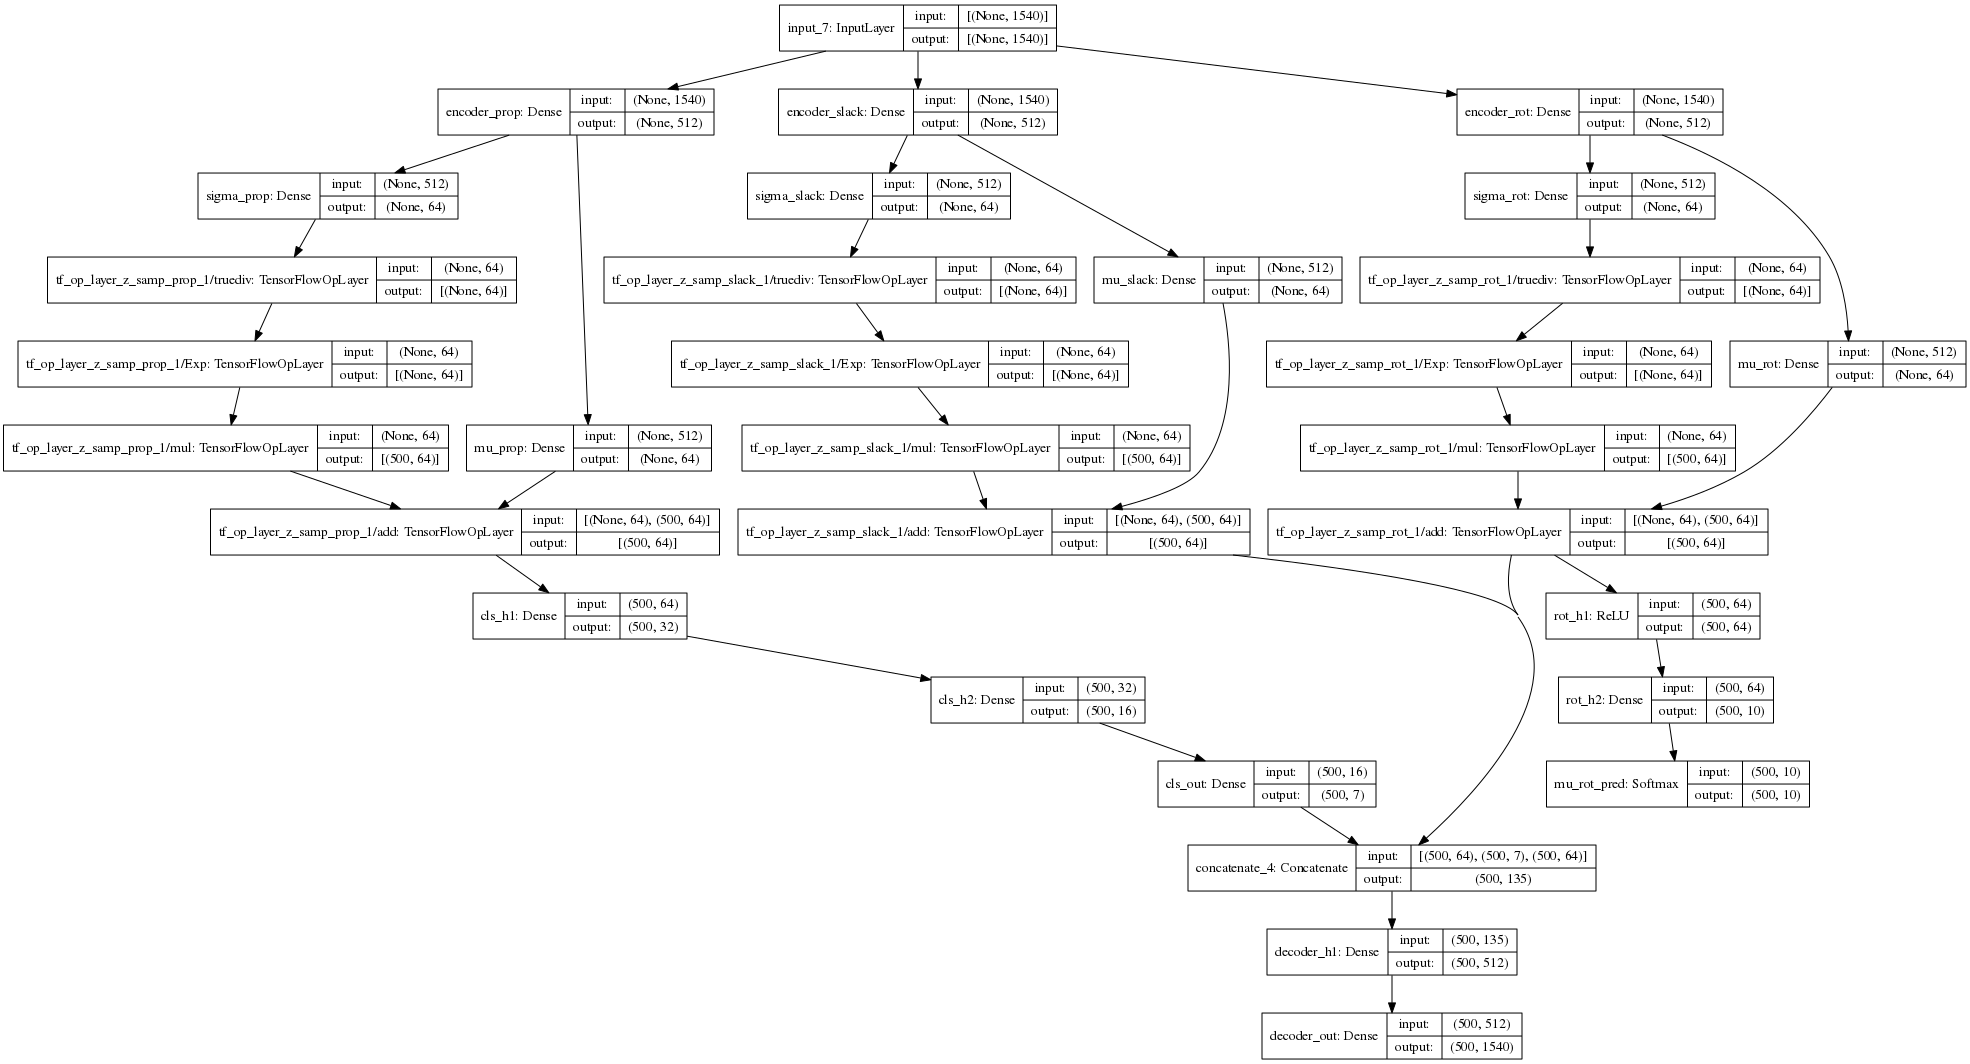

In [49]:
display(plot_model(unknown_prop_vae, show_layer_names=True, show_shapes=True, dpi=72))

# **Training**

Here we train using both the known and unknown cell-type proportions.
The labeled data is repeated in order to match the dimension of the unlabeled data so that they have the same batch size.
This code is taken from https://github.com/bjlkeng/sandbox/blob/master/notebooks/vae-semi_supervised_learning/vae-m2-fit-mnist.ipynb

In [50]:
def fit_model_M1(known_prop_vae, unknown_prop_vae, X_unknown_prop,
              label_unknown_prop, X_known_prop, Y_known_prop, 
              label_known_prop, epochs, batch_size):
    assert len(X_unknown_prop) % len(X_known_prop) == 0, \
            (len(X_unknown_prop), batch_size, len(X_known_prop))
    start = time.time()
    history = []
    
    for epoch in range(epochs):
        unlabeled_index = np.arange(len(X_unknown_prop))
        np.random.shuffle(unlabeled_index)

        # Repeat the unlabeled data to match length of labeled data
        labeled_index = []
        for i in range(len(X_unknown_prop) // len(X_known_prop)):
            l = np.arange(len(X_known_prop))
            np.random.shuffle(l)
            labeled_index.append(l)
        labeled_index = np.concatenate(labeled_index)
        
        batches = len(X_unknown_prop) // batch_size
        for i in range(batches):
            # Labeled
            index_range =  labeled_index[i * batch_size:(i+1) * batch_size]
            loss = known_prop_vae.train_on_batch(X_known_prop[index_range], 
                                                    [X_known_prop[index_range], Y_known_prop[index_range], label_known_prop[index_range]])
            
            # Unlabeled
            #y_shuffle = np.identity(8, dtype=np.float32)
            #for idx in range(0, 49):
            #    y_shuffle = np.vstack((y_shuffle, np.identity(8, dtype=np.float32)))
            #np.random.shuffle(y_shuffle)
            #y_shuffle = np.zeros((batch_size, 8))
            #y_shuffle[:,0] = 1
            index_range =  unlabeled_index[i * batch_size:(i+1) * batch_size]
            loss += [unknown_prop_vae.train_on_batch(X_unknown_prop[index_range], 
                                                        [X_unknown_prop[index_range], label_unknown_prop[index_range]])]
                                                        #[X_unknown_prop[index_range], Y_unknown_prop[index_range], label_unknown_prop[index_range], drug_unknown_prop[index_range]])]
            
            history.append(loss)
            
    
   
    done = time.time()
    elapsed = done - start
    print("Elapsed: ", elapsed)
    
    return history


def fit_model_M2(known_prop_vae, unknown_prop_vae, X_unknown_prop, label_unknown_prop, X_known_prop, Y_known_prop, label_known_prop, epochs):
    assert len(X_unknown_prop) % len(X_known_prop) == 0, \
            (len(X_unknown_prop), batch_size, len(X_known_prop))
    start = time.time()
    history = []
    
    for epoch in range(epochs):
        unlabeled_index = np.arange(len(X_unknown_prop))
        np.random.shuffle(unlabeled_index)

        # Repeat the unlabeled data to match length of labeled data
        labeled_index = []
        for i in range(len(X_unknown_prop) // len(X_known_prop)):
            l = np.arange(len(X_known_prop))
            np.random.shuffle(l)
            labeled_index.append(l)
        labeled_index = np.concatenate(labeled_index)
        
        batches = len(X_unknown_prop) // batch_size
        for i in range(batches):
            # Labeled
            index_range =  labeled_index[i * batch_size:(i+1) * batch_size]
            loss = known_prop_vae.train_on_batch([X_known_prop[index_range], Y_known_prop[index_range]],
                                                    [X_known_prop[index_range], Y_known_prop[index_range], label_known_prop[index_range]])
            
            # Unlabeled
            index_range =  unlabeled_index[i * batch_size:(i+1) * batch_size]
            loss += [unknown_prop_vae.train_on_batch(X_unknown_prop[index_range],
                                                        [X_unknown_prop[index_range], label_unknown_prop[index_range]])]


            history.append(loss)
            
    
   
    done = time.time()
    elapsed = done - start
    print("Elapsed: ", elapsed)
    
    return history

Now train

In [51]:
# helper methods for evaluation
def sum_abs_error(y_pred, y_true):
  return sum(abs(y_pred - y_true))

def mean_abs_error(y_pred, y_true):
  return np.mean(abs(y_pred - y_true))

def mean_sqr_error(y_pred, y_true):
  return np.mean((y_pred - y_true)**2)

def get_errors(y_true, y_est):
  mse_err = [mean_sqr_error(y_true[idx], y_est[idx]) 
                  for idx in range(0, y_est.shape[0])]

  print(f"MSqE mean: {np.mean(mse_err)}, median: {np.median(mse_err)}, max: {max(mse_err)}")

  spr_err = [spearmanr(y_true[idx].astype(float), y_est[idx].astype(float))[0]
                    for idx in range(0, y_est.shape[0])]
  print(f"Spearman mean: {np.mean(spr_err)}, median: {np.median(spr_err)}, max: {max(spr_err)}")

  pear_err = [pearsonr(y_true[idx].astype(float), y_est[idx].astype(float))[0]
                    for idx in range(0, y_est.shape[0])]
  print(f"Pearson mean: {np.mean(pear_err)}, median: {np.median(pear_err)}, max: {max(pear_err)}")

  error_list = [mse_err, spr_err, pear_err]
  plot_df = [item for sublist in error_list for item in sublist]
  plot_df = pd.DataFrame(plot_df)
  plot_df.columns = ["error"]
  plot_df["error_type"] = ["MSQ"]*y_est.shape[0] + ["SPR"]*y_est.shape[0] + ["PEAR"]*y_est.shape[0]

  return plot_df


In [52]:
unlabeled_index = np.arange(len(X_unkp))
np.random.shuffle(unlabeled_index)

labeled_index = np.arange(len(X_kp))
np.random.shuffle(labeled_index)

X_unkp[unlabeled_index[0:4000]].shape


(4000, 1540)

In [94]:
#epoch_vec = [100]*10
#epoch_vec = list(range(500, 100, -100))

epoch_vec = [10]*10

optim = Adam(learning_rate=0.001)
LR = 0.001

loss_history_M1 = None
loss_history_M2 = None

for curr_epoch in epoch_vec:
    
    known_prop_vae.compile(optimizer=optim, loss=[vae_loss, prop_loss, class_loss]) #, metrics = [KL_loss, recon_loss])
    unknown_prop_vae.compile(optimizer=optim, loss=[vae_loss, class_loss]) #, metrics = [KL_loss, recon_loss])

    known_prop_vae_M1.compile(optimizer=optim, loss=[vae_loss, prop_loss, class_loss, None])
    unknown_prop_vae_M1.compile(optimizer=optim, loss=[vae_loss_unk, class_loss])


    
    unlabeled_index = np.arange(len(X_unkp))
    labeled_index = np.arange(len(X_kp))

    np.random.shuffle(unlabeled_index)
    curr_unlab_idx = unlabeled_index[0:8000]

    np.random.shuffle(labeled_index)
    curr_lab_idx = labeled_index[0:2000]

    print(f"{curr_epoch} M2 Start")                                
    loss_history_M2_curr = fit_model_M2(known_prop_vae, 
                                unknown_prop_vae,
                                X_unkp[curr_unlab_idx],
                                label_unkp[curr_unlab_idx],
                                X_kp[curr_lab_idx], 
                                y_kp[curr_lab_idx],
                                label_kp[curr_lab_idx],
                                epochs=curr_epoch)
    
    np.random.shuffle(unlabeled_index)
    curr_unlab_idx = unlabeled_index[0:8000]

    np.random.shuffle(labeled_index)
    curr_lab_idx = labeled_index[0:2000]
    

    print(f"{curr_epoch} M1 Start")
    loss_history_M1_curr = fit_model_M1(known_prop_vae_M1, 
                                    unknown_prop_vae_M1,
                                    X_unkp[curr_unlab_idx],
                                    label_unkp[curr_unlab_idx],
                                    X_kp[curr_lab_idx], 
                                    y_kp[curr_lab_idx],
                                    label_kp[curr_lab_idx], 
                                    epochs=curr_epoch,
                                    batch_size=batch_size)

    if loss_history_M1 is None:
        loss_history_M1 = loss_history_M1_curr
    else:
        loss_history_M1.extend(loss_history_M1_curr)

    if loss_history_M2 is None:
        loss_history_M2 = loss_history_M2_curr
    else:
        loss_history_M2.extend(loss_history_M2_curr)


10 M2 Start
Elapsed:  21.15933918952942
10 M1 Start
Elapsed:  20.888485193252563
10 M2 Start
Elapsed:  22.007535934448242
10 M1 Start
Elapsed:  20.850889682769775
10 M2 Start
Elapsed:  24.28241515159607
10 M1 Start
Elapsed:  21.536012887954712
10 M2 Start
Elapsed:  23.441726446151733
10 M1 Start
Elapsed:  23.487167835235596
10 M2 Start
Elapsed:  24.546164989471436
10 M1 Start
Elapsed:  23.58502507209778
10 M2 Start
Elapsed:  25.73452138900757
10 M1 Start
Elapsed:  24.142539262771606
10 M2 Start
Elapsed:  26.4780912399292
10 M1 Start
Elapsed:  24.972940921783447
10 M2 Start
Elapsed:  29.399983406066895
10 M1 Start
Elapsed:  26.081066846847534
10 M2 Start
Elapsed:  28.51766085624695
10 M1 Start
Elapsed:  27.493334531784058
10 M2 Start
Elapsed:  29.988706827163696
10 M1 Start
Elapsed:  28.013559818267822


# Plot Loss Curves

In [95]:
def read_loss_file(res_path, exp_id, unlab_id):
    loss_file = os.path.join(res_path, f"train-{exp_id}-{unlab_id}-DIVA_loss.pkl")
    loss_path = Path(loss_file)
    loss_df = pickle.load( open( loss_path, "rb" ) )
    return loss_df

def make_loss_fig(loss_df, ax, title, loss_to_plot):
    ## plot loss
    g = sns.lineplot(
        x="batch", y=loss_to_plot,
        data=loss_df,
        hue="type",
        legend="full",
        alpha=0.3, ax= ax
    )
    ax.set_title(title)
    return g

In [96]:
def get_loss_df(loss_history):
    labeled_total_loss = [item[0] for item in loss_history]
    unlabeled_total_loss = [item[4][0] for item in loss_history]

    labeled_recon_loss = [item[1] for item in loss_history]
    unlabeled_recon_loss = [item[4][1] for item in loss_history]

    labeled_prop_loss = [item[2] for item in loss_history]
    unlabeled_prop_loss = [item[4][2] for item in loss_history]

    labeled_samp_loss = [item[3] for item in loss_history]
    unlabeled_samp_loss = [item[4][3] for item in loss_history]


    # make into a dataframe
    total_loss = labeled_total_loss + unlabeled_total_loss + [a + b for a, b in zip(labeled_total_loss, unlabeled_total_loss)]
    loss_df = pd.DataFrame(data=total_loss, columns=['total_loss'])
    loss_df['type'] = ["labeled"]*len(loss_history) + ["unlabeled"]*len(loss_history) + ["sum"]*len(loss_history)
    loss_df['batch'] = [*range(len(loss_history))] + [*range(len(loss_history))] + [*range(len(loss_history))]

    recon_loss = labeled_recon_loss + unlabeled_recon_loss + [a + b for a, b in zip(labeled_recon_loss, unlabeled_recon_loss)]
    loss_df['recon_loss'] = recon_loss

    prop_loss = labeled_prop_loss + unlabeled_prop_loss + labeled_prop_loss
    loss_df['prop_loss'] = prop_loss

    samp_loss = labeled_samp_loss + unlabeled_samp_loss + [a + b for a, b in zip(labeled_samp_loss, unlabeled_samp_loss)]
    loss_df['samp_loss'] = samp_loss

    return loss_df

def get_loss_df_noUnLab(loss_history):
    labeled_total_loss = [item[0] for item in loss_history]
    unlabeled_total_loss = [item[4][0] for item in loss_history]

    labeled_recon_loss = [item[1] for item in loss_history]
    unlabeled_recon_loss = [item[4][1] for item in loss_history]

    labeled_prop_loss = [item[2] for item in loss_history]

    labeled_samp_loss = [item[3] for item in loss_history]
    unlabeled_samp_loss = [item[4][2] for item in loss_history]


    # make into a dataframe
    total_loss = labeled_total_loss + unlabeled_total_loss + [a + b for a, b in zip(labeled_total_loss, unlabeled_total_loss)]
    loss_df = pd.DataFrame(data=total_loss, columns=['total_loss'])
    loss_df['type'] = ["labeled"]*len(loss_history) + ["unlabeled"]*len(loss_history) + ["sum"]*len(loss_history)
    loss_df['batch'] = [*range(len(loss_history))] + [*range(len(loss_history))] + [*range(len(loss_history))]

    recon_loss = labeled_recon_loss + unlabeled_recon_loss + [a + b for a, b in zip(labeled_recon_loss, unlabeled_recon_loss)]
    loss_df['recon_loss'] = recon_loss

    prop_loss = labeled_prop_loss + [0]*len(loss_history) + labeled_prop_loss
    loss_df['prop_loss'] = prop_loss

    samp_loss = labeled_samp_loss + unlabeled_samp_loss + [a + b for a, b in zip(labeled_samp_loss, unlabeled_samp_loss)]
    loss_df['samp_loss'] = samp_loss

    return loss_df

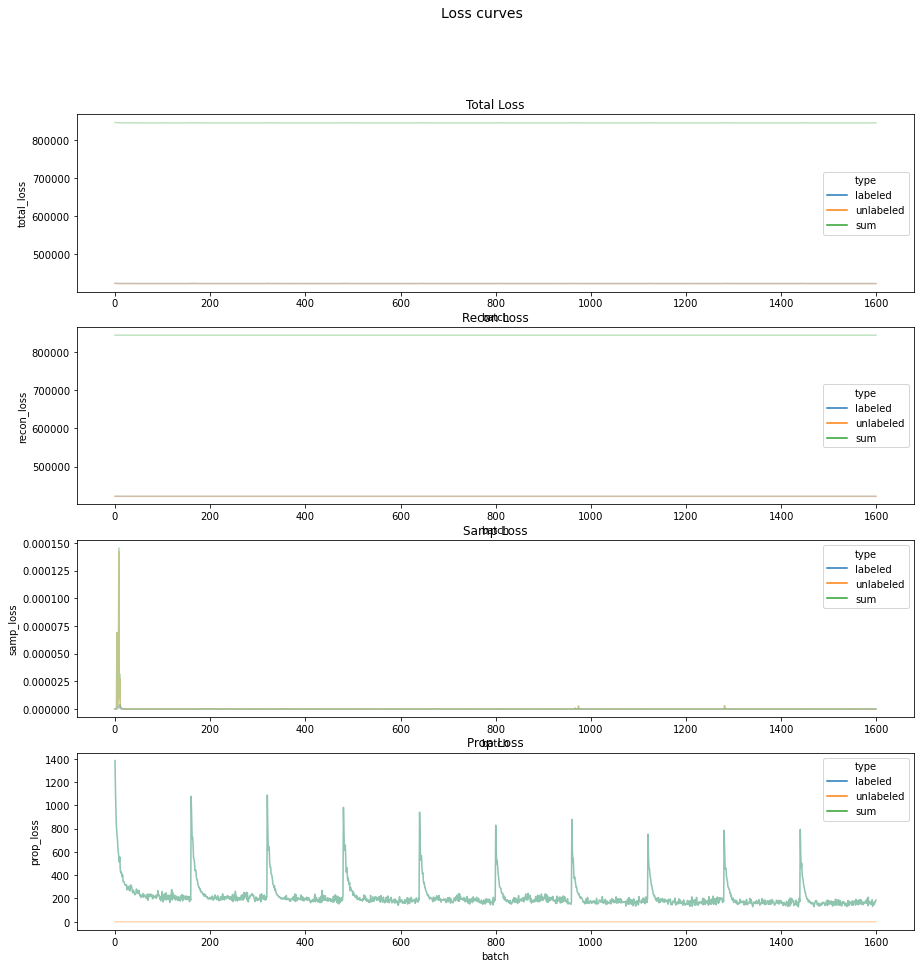

In [97]:
# write out the loss for later plotting
# unpack the loss values
loss_history_M1_df = get_loss_df_noUnLab(loss_history_M1)

fig, axs = plt.subplots(4, figsize=(15,15))

make_loss_fig(loss_history_M1_df, ax=axs[0], title=f"Total Loss", loss_to_plot="total_loss")
make_loss_fig(loss_history_M1_df, ax=axs[1], title=f"Recon Loss", loss_to_plot="recon_loss")
make_loss_fig(loss_history_M1_df, ax=axs[2], title=f"Samp Loss", loss_to_plot="samp_loss")
make_loss_fig(loss_history_M1_df, ax=axs[3], title=f"Prop Loss", loss_to_plot="prop_loss")


fig.suptitle("Loss curves", fontsize=14)

fig.show()



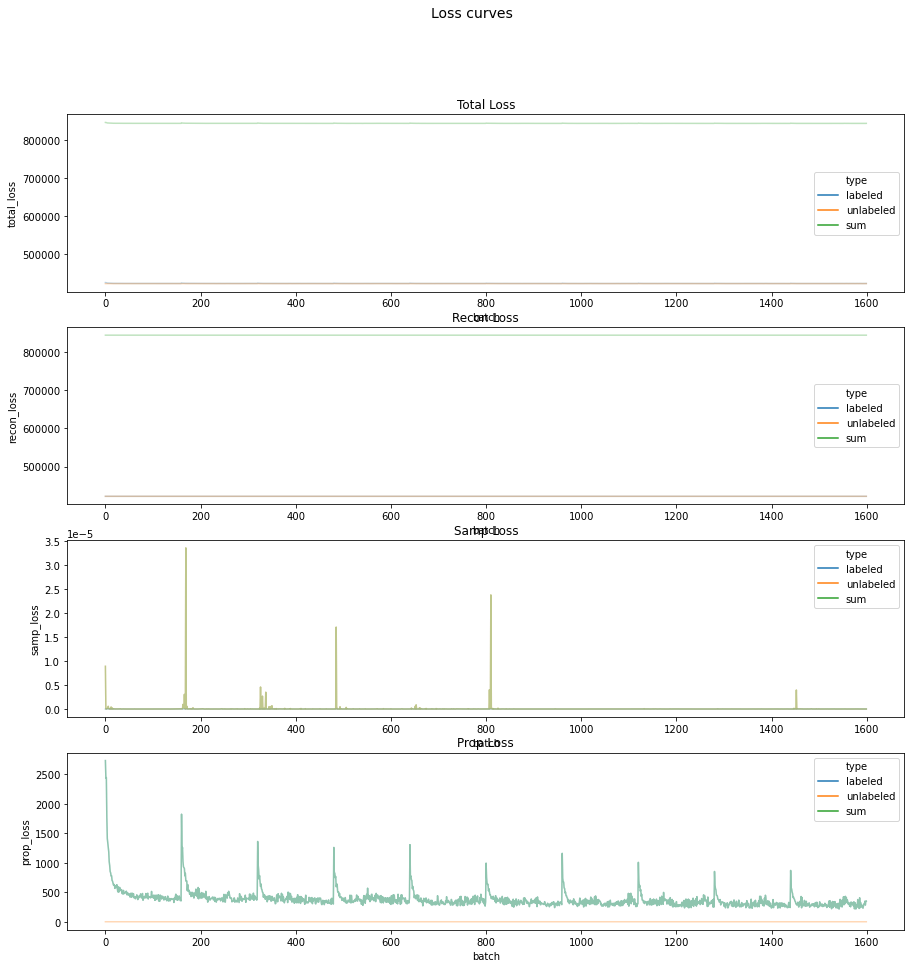

In [98]:
# write out the loss for later plotting
# unpack the loss values
loss_history_M2_df = get_loss_df_noUnLab(loss_history_M2)

fig, axs = plt.subplots(4, figsize=(15,15))

make_loss_fig(loss_history_M2_df, ax=axs[0], title=f"Total Loss", loss_to_plot="total_loss")
make_loss_fig(loss_history_M2_df, ax=axs[1], title=f"Recon Loss", loss_to_plot="recon_loss")
make_loss_fig(loss_history_M2_df, ax=axs[2], title=f"Samp Loss", loss_to_plot="samp_loss")
make_loss_fig(loss_history_M2_df, ax=axs[3], title=f"Prop Loss", loss_to_plot="prop_loss")


fig.suptitle("Loss curves", fontsize=14)

fig.show()

In [99]:
def plot_cell_specific_corr(xval, yval, ax, title, xlab, ylab, class_id):

    plot_df = pd.DataFrame(list(zip(xval, yval)))
    plot_df.columns = [xlab, ylab]

    g = sns.scatterplot(
        x=xlab, y=ylab,
        data=plot_df,ax=ax,
        hue=class_id
    )
    g.set(ylim=(0, 1))
    g.set(xlim=(0, 1))
    g.plot([0, 1], [0, 1], transform=g.transAxes)

    ax.set_title(title)
    return g

In [100]:
label_unkp

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

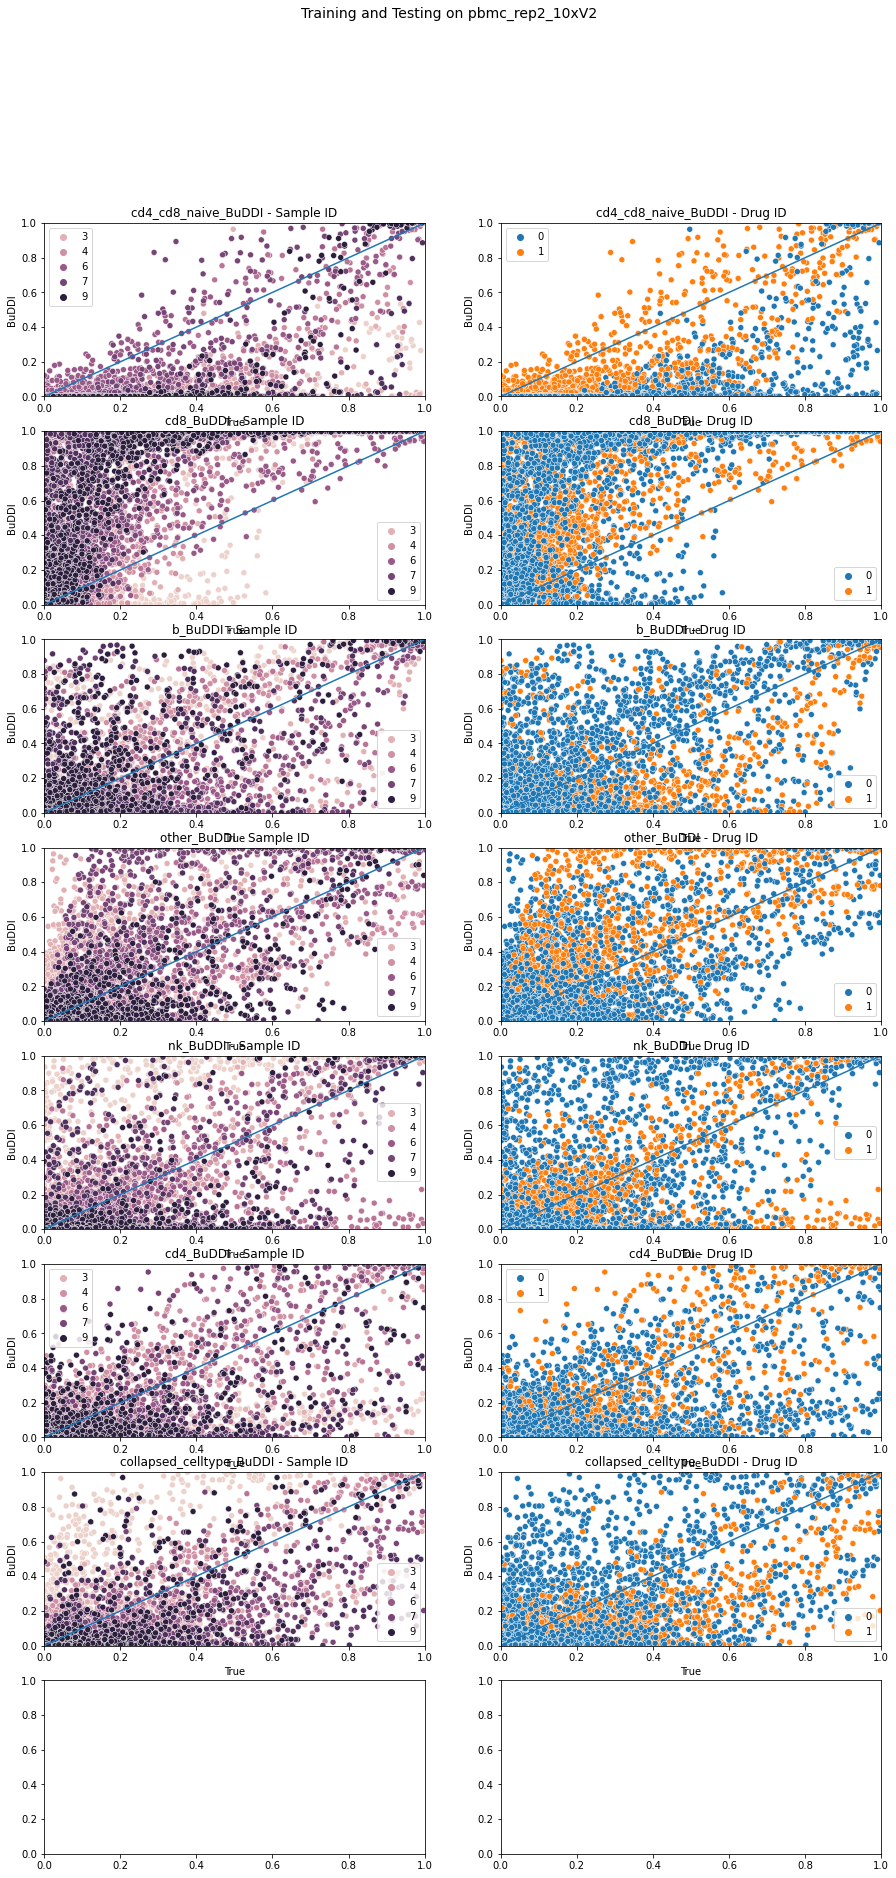

In [101]:
# make predictions
prop_outputs = classifier.predict(X_unkp, batch_size=batch_size)

## plot for the unlabeled

prop_df = pd.DataFrame(prop_outputs, columns=Y_train.columns)
true_prop_df = Y_train.iloc[idx_unlab]

fig, axs = plt.subplots(8, 2, figsize=(15,30))
row_idx = 0
for curr_cell in true_prop_df.columns:

    plot_cell_specific_corr(true_prop_df[curr_cell], prop_df[curr_cell], axs[row_idx,0], title=f"{curr_cell}_BuDDI - Sample ID", xlab="True", ylab="BuDDI", class_id=Label_full[idx_unlab])
    plot_cell_specific_corr(true_prop_df[curr_cell], prop_df[curr_cell], axs[row_idx,1], title=f"{curr_cell}_BuDDI - Drug ID", xlab="True", ylab="BuDDI", class_id=Drug_full[idx_unlab])
    row_idx = row_idx +1


fig.suptitle("Training and Testing on pbmc_rep2_10xV2", fontsize=14)

fig.show()

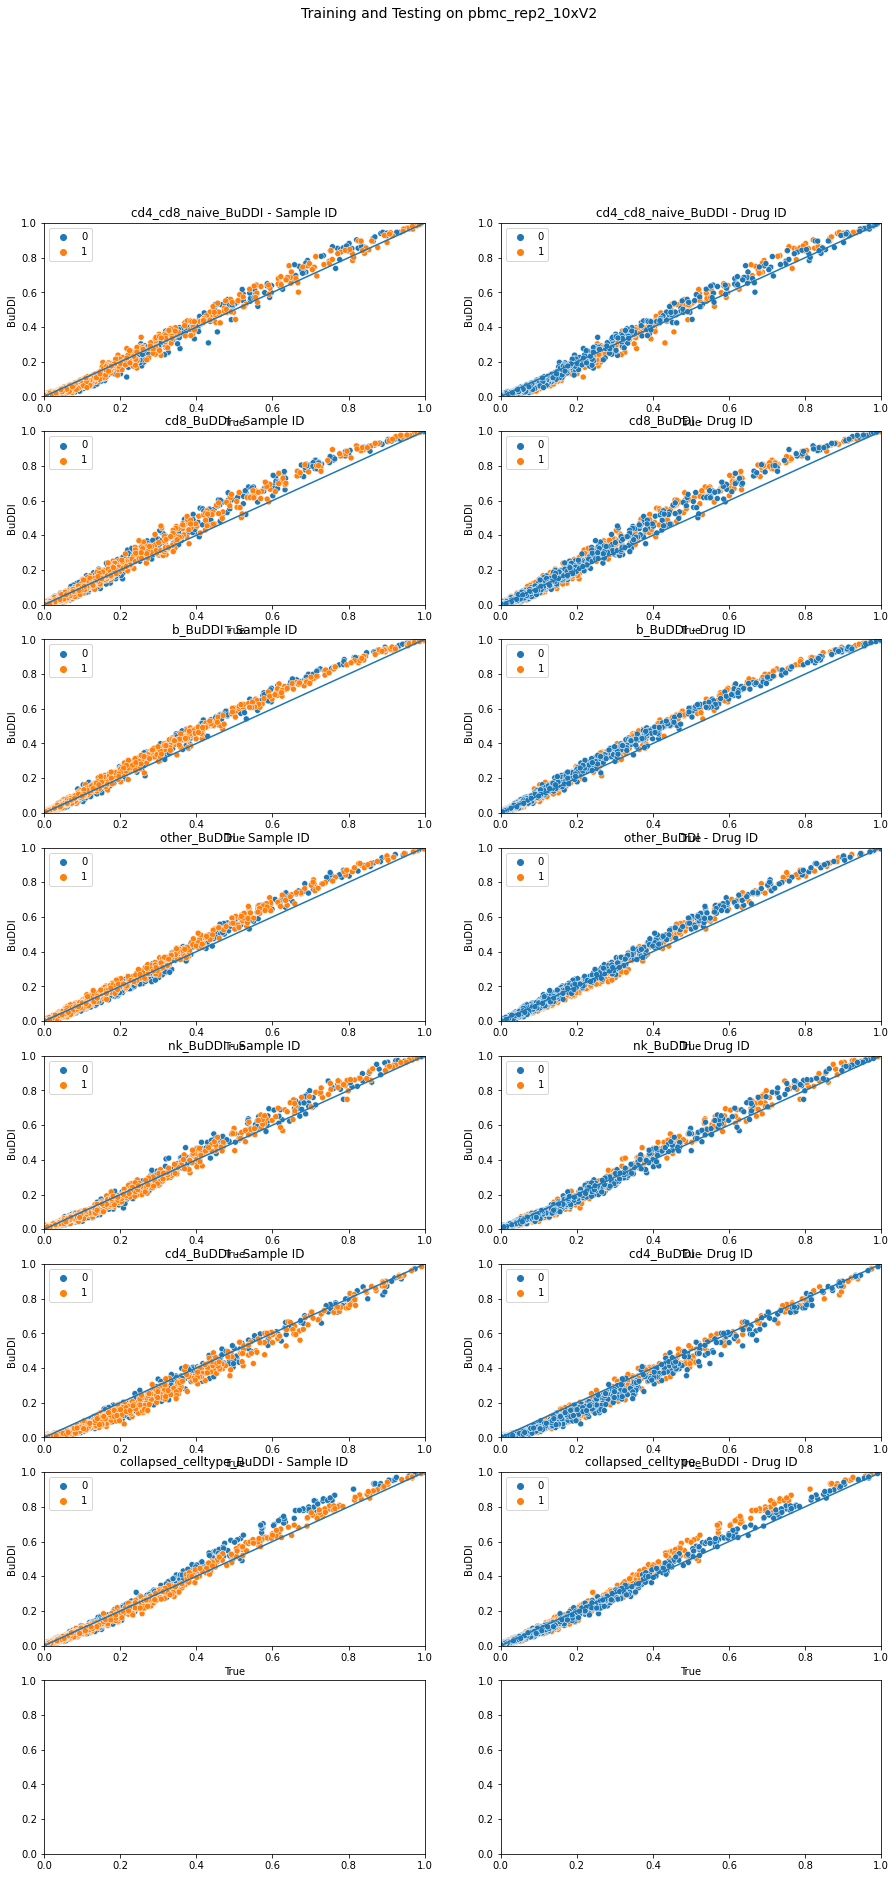

In [102]:
# make predictions
prop_outputs = classifier.predict(X_kp, batch_size=batch_size)


## plot for the labeled

prop_df = pd.DataFrame(prop_outputs, columns=Y_train.columns)
true_prop_df = Y_train.iloc[idx_train]

fig, axs = plt.subplots(8, 2, figsize=(15,30))
row_idx = 0
for curr_cell in true_prop_df.columns:

    plot_cell_specific_corr(true_prop_df[curr_cell], prop_df[curr_cell], axs[row_idx,0], title=f"{curr_cell}_BuDDI - Sample ID", xlab="True", ylab="BuDDI", class_id=Label_full[idx_train])
    plot_cell_specific_corr(true_prop_df[curr_cell], prop_df[curr_cell], axs[row_idx,1], title=f"{curr_cell}_BuDDI - Drug ID", xlab="True", ylab="BuDDI", class_id=Drug_full[idx_train])
    row_idx = row_idx +1


fig.suptitle("Training and Testing on pbmc_rep2_10xV2", fontsize=14)

fig.show()

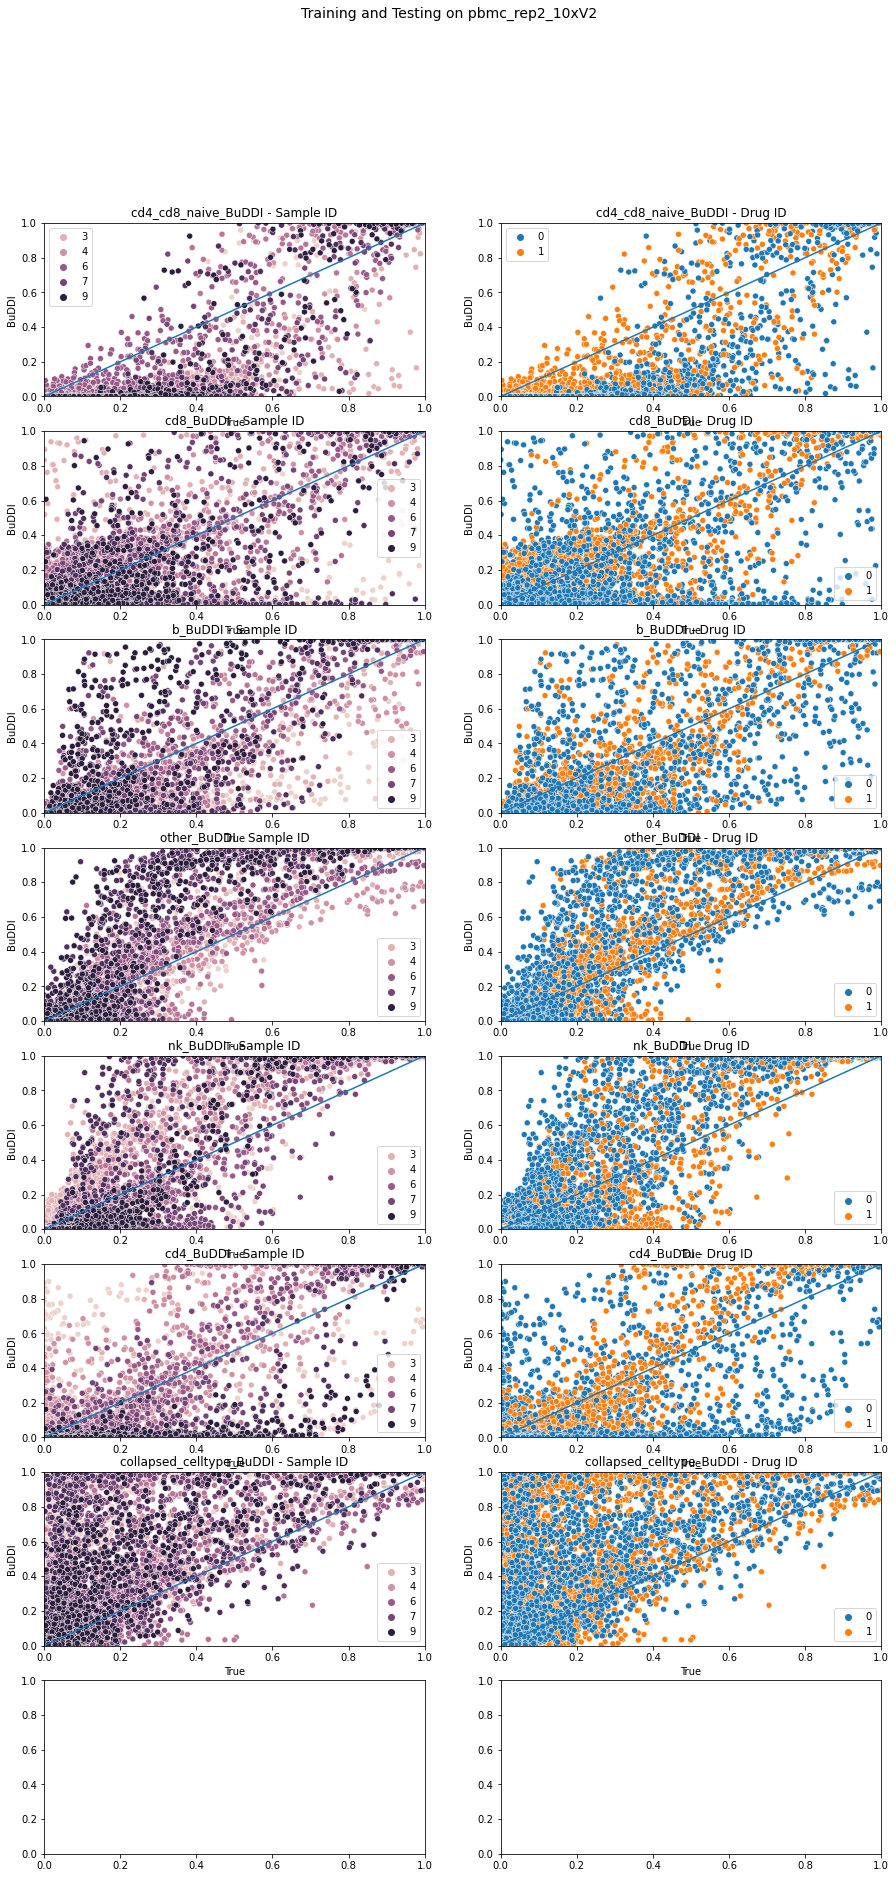

In [103]:

z_slack, mu_slack, l_sigma_slack, mu_prop, l_sigma_prop, prop_outputs, z_rot, mu_rot, l_sigma_rot = encoder.predict(X_unkp, batch_size=batch_size)
z_test = prop_outputs
encodings = np.asarray(z_test)

## plot for the unlabeled

prop_df = pd.DataFrame(prop_outputs, columns=Y_train.columns)
true_prop_df = Y_train.iloc[idx_unlab]

fig, axs = plt.subplots(8, 2, figsize=(15,30))
row_idx = 0
for curr_cell in true_prop_df.columns:

    plot_cell_specific_corr(true_prop_df[curr_cell], prop_df[curr_cell], axs[row_idx,0], title=f"{curr_cell}_BuDDI - Sample ID", xlab="True", ylab="BuDDI", class_id=Label_full[idx_unlab])
    plot_cell_specific_corr(true_prop_df[curr_cell], prop_df[curr_cell], axs[row_idx,1], title=f"{curr_cell}_BuDDI - Drug ID", xlab="True", ylab="BuDDI", class_id=Drug_full[idx_unlab])
    row_idx = row_idx +1


fig.suptitle("Training and Testing on pbmc_rep2_10xV2", fontsize=14)

fig.show()

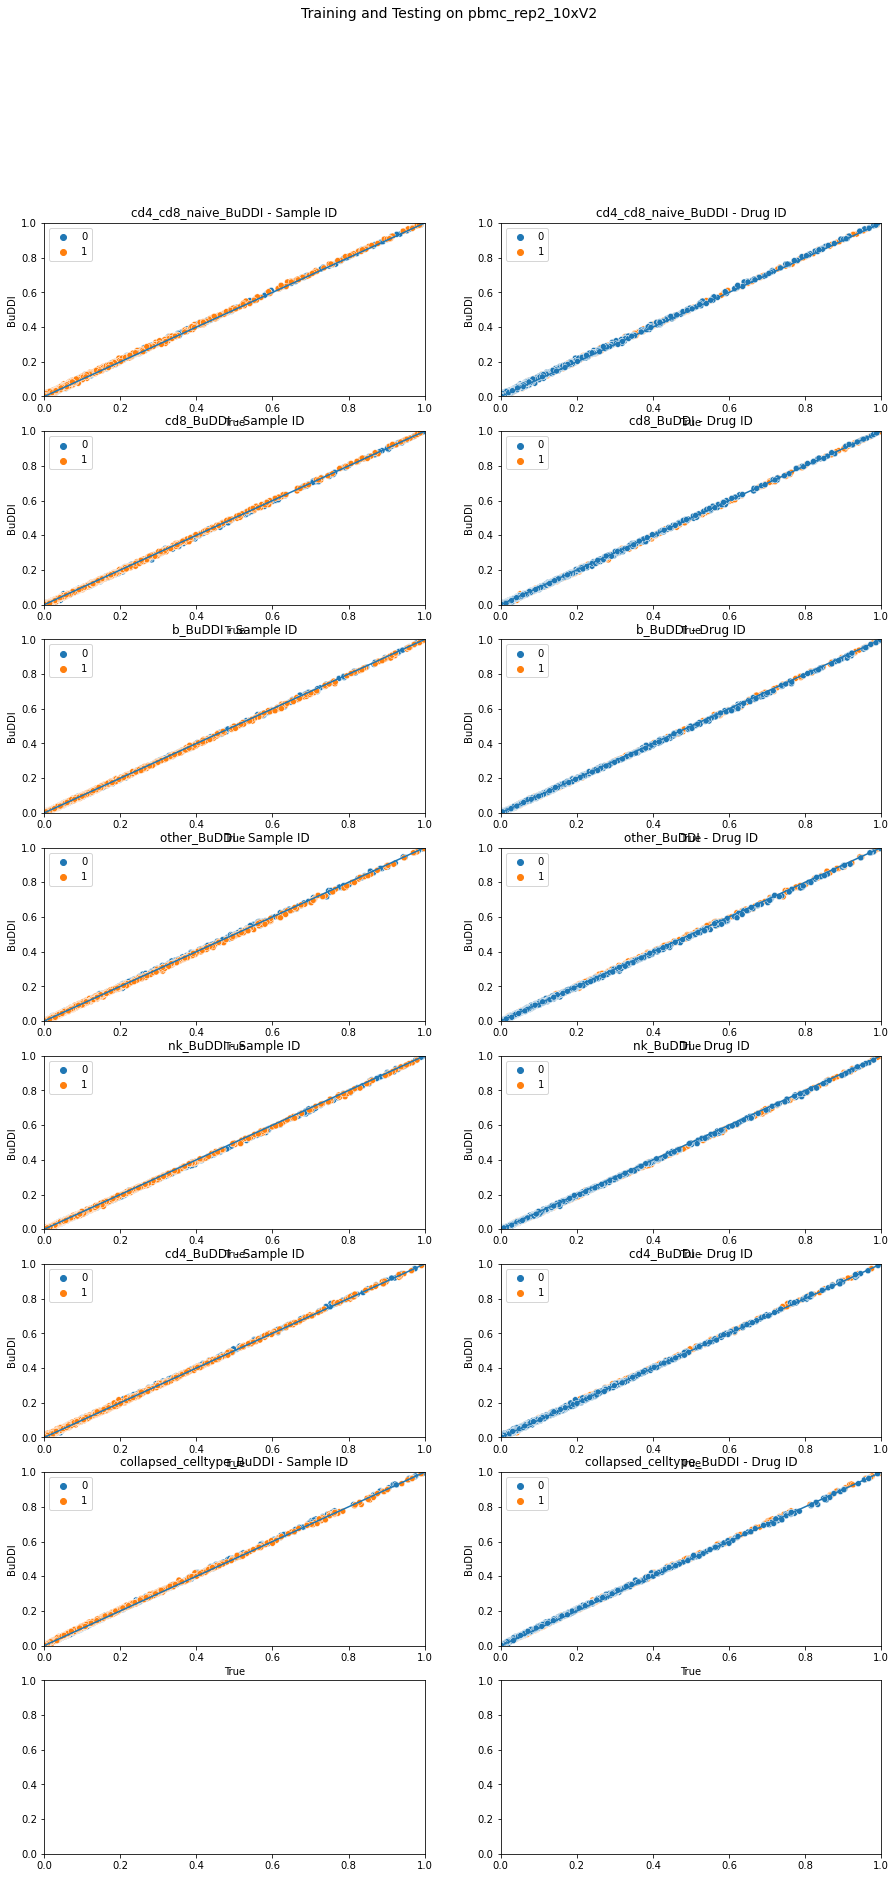

In [104]:
z_slack, mu_slack, l_sigma_slack, mu_prop, l_sigma_prop, prop_outputs, z_rot, mu_rot, l_sigma_rot = encoder.predict(X_kp, batch_size=batch_size)
z_test = prop_outputs
encodings = np.asarray(z_test)

## plot for the unlabeled

## plot for the labeled

prop_df = pd.DataFrame(prop_outputs, columns=Y_train.columns)
true_prop_df = Y_train.iloc[idx_train]

fig, axs = plt.subplots(8, 2, figsize=(15,30))
row_idx = 0
for curr_cell in true_prop_df.columns:

    plot_cell_specific_corr(true_prop_df[curr_cell], prop_df[curr_cell], axs[row_idx,0], title=f"{curr_cell}_BuDDI - Sample ID", xlab="True", ylab="BuDDI", class_id=Label_full[idx_train])
    plot_cell_specific_corr(true_prop_df[curr_cell], prop_df[curr_cell], axs[row_idx,1], title=f"{curr_cell}_BuDDI - Drug ID", xlab="True", ylab="BuDDI", class_id=Drug_full[idx_train])
    row_idx = row_idx +1


fig.suptitle("Training and Testing on pbmc_rep2_10xV2", fontsize=14)

fig.show()

# **Inspect the output**

## TSNE training data

Now that we know what is expected, let's see what we get from the model. We find that out of our encoder, after applying ReLU, we get pretty close to the expected proportions.

In [105]:
def get_tsne_for_plotting(encodings):
    tsne = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=500)
    tsne_results = tsne.fit_transform(encodings)

    plot_df = pd.DataFrame(tsne_results[:,0:2])
    print(tsne_results.shape)
    print(plot_df.shape)
    plot_df.columns = ['tsne_0', 'tsne_1']
    return plot_df

def plot_tsne(plot_df, color_vec, ax, title):

    shuff_idx = np.arange(len(plot_df))
    np.random.shuffle(shuff_idx)
    plot_df = plot_df.iloc[shuff_idx]
    color_vec = color_vec[shuff_idx]

    plot_df['Y'] = color_vec

    g = sns.scatterplot(
        x="tsne_0", y="tsne_1",
        data=plot_df,
        hue="Y",
        palette=sns.color_palette("hls", len(np.unique(color_vec))),
        legend="full",
        alpha=0.3, ax= ax
    )

    ax.set_title(title)
    return g


Number unique Y: 7


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.001s...
[t-SNE] Computed neighbors for 10000 samples in 2.589s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 4.213210
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.748314
[t-SNE] KL divergence after 500 iterations: 1.395329
(10000, 2)
(10000, 2)


/tmp/ipykernel_25748/802616448.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['Y'] = color_vec
/tmp/ipykernel_25748/802616448.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['Y'] = color_vec
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packa

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.001s...
[t-SNE] Computed neighbors for 10000 samples in 2.107s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 141.501282
[t-SNE] KL divergence after 500 iterations: 4.307055
(10000, 2)
(10000, 2)


/tmp/ipykernel_25748/802616448.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['Y'] = color_vec
/tmp/ipykernel_25748/802616448.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['Y'] = color_vec
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packa

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.014s...
[t-SNE] Computed neighbors for 10000 samples in 3.505s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.724206
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.509666
[t-SNE] KL divergence after 500 iterations: 1.347838
(10000, 2)
(10000, 2)


/tmp/ipykernel_25748/802616448.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['Y'] = color_vec
/tmp/ipykernel_25748/802616448.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['Y'] = color_vec


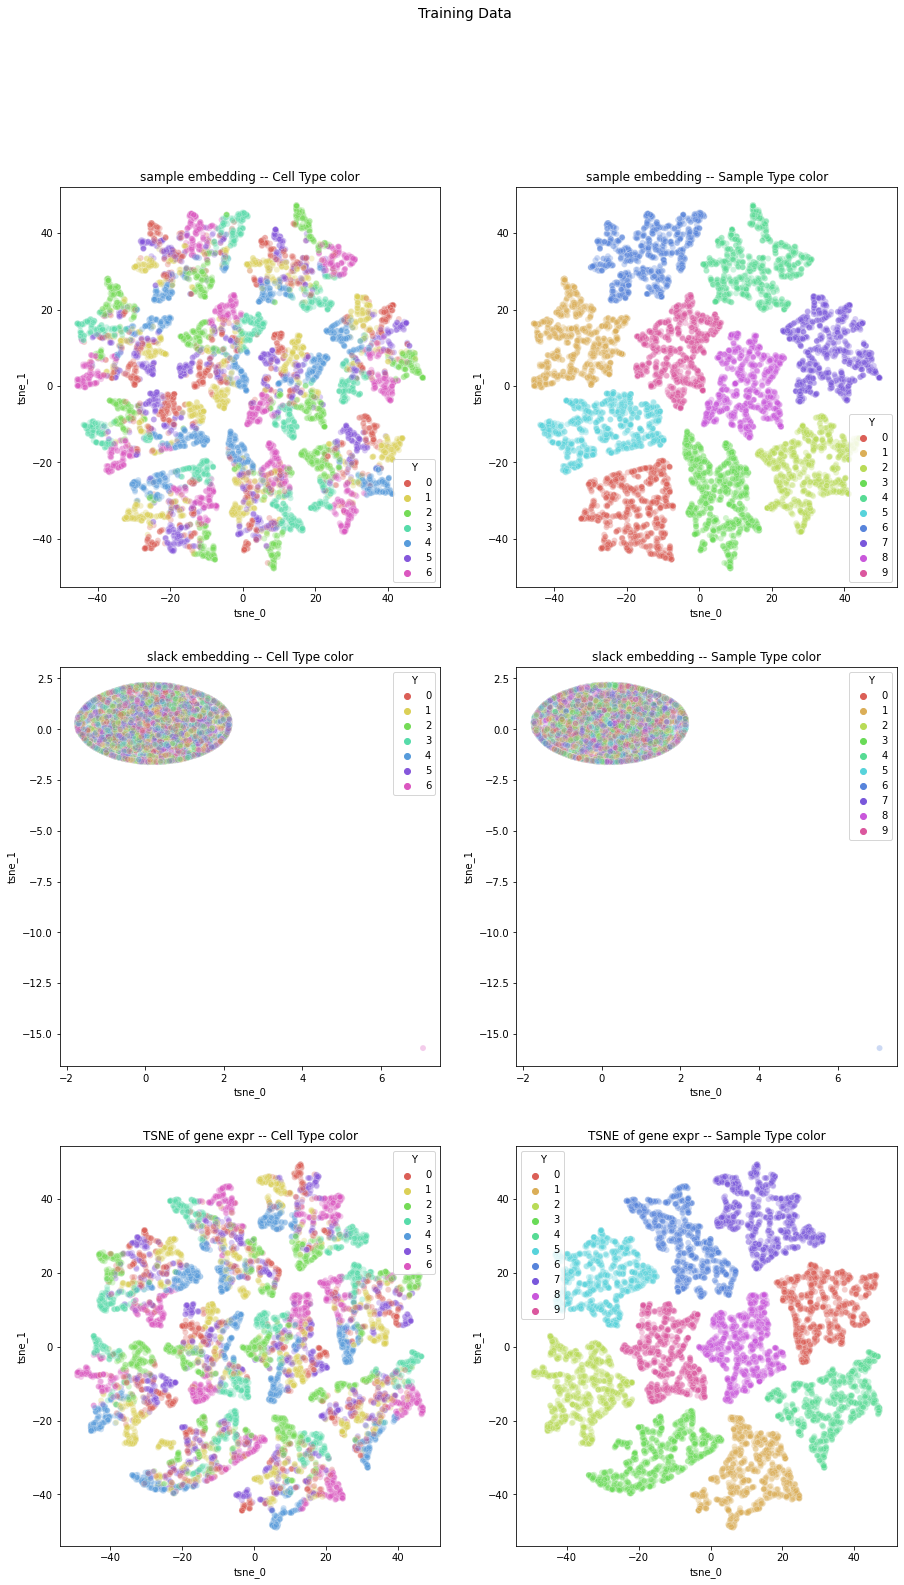

In [106]:
batch_size = 500
# plot proportions on labeled 10x and unlabeled 10x
# this is the training data

X_temp = X_full
X_temp = scale(X_temp, axis=1)

Y_temp = Y_full
Y_temp = np.argmax(Y_temp, axis=1)

label_temp = Label_full

print(f"Number unique Y: {len(np.unique(Y_temp))}")


z_slack, mu_slack, l_sigma_slack, z_rot, mu_rot, l_sigma_rot = encoder_unlab.predict(X_temp, batch_size=batch_size)



fig, axs = plt.subplots(3, 2, figsize=(15,25))


plot_df = get_tsne_for_plotting(np.asarray(mu_rot))
plot_tsne(plot_df, color_vec=Y_temp, ax=axs[0,0], title="sample embedding -- Cell Type color")
plot_tsne(plot_df, color_vec=label_temp, ax=axs[0,1], title="sample embedding -- Sample Type color")

plot_df = get_tsne_for_plotting(np.asarray(mu_slack))
plot_tsne(plot_df, color_vec=Y_temp, ax=axs[1,0], title="slack embedding -- Cell Type color")
plot_tsne(plot_df, color_vec=label_temp, ax=axs[1,1], title="slack embedding -- Sample Type color")

plot_df = get_tsne_for_plotting(np.asarray(X_temp))
plot_tsne(plot_df, color_vec=Y_temp, ax=axs[2,0], title="TSNE of gene expr -- Cell Type color")
plot_tsne(plot_df, color_vec=label_temp, ax=axs[2,1], title="TSNE of gene expr -- Sample Type color")



fig.suptitle("Training Data", fontsize=14)

fig.show()

Number unique Y: 7


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.001s...
[t-SNE] Computed neighbors for 10000 samples in 2.698s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 6.019231
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.906235
[t-SNE] KL divergence after 500 iterations: 1.630877
(10000, 2)
(10000, 2)


/tmp/ipykernel_25748/802616448.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['Y'] = color_vec
/tmp/ipykernel_25748/802616448.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['Y'] = color_vec
/tmp/ipykernel_25748/802616448.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.001s...
[t-SNE] Computed neighbors for 10000 samples in 2.558s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 4.213210
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.919243
[t-SNE] KL divergence after 500 iterations: 1.400193
(10000, 2)
(10000, 2)


/tmp/ipykernel_25748/802616448.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['Y'] = color_vec
/tmp/ipykernel_25748/802616448.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['Y'] = color_vec
/tmp/ipykernel_25748/802616448.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.001s...
[t-SNE] Computed neighbors for 10000 samples in 2.214s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 145.938171
[t-SNE] KL divergence after 500 iterations: 4.225285
(10000, 2)
(10000, 2)


/tmp/ipykernel_25748/802616448.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['Y'] = color_vec
/tmp/ipykernel_25748/802616448.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['Y'] = color_vec
/tmp/ipykernel_25748/802616448.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.010s...
[t-SNE] Computed neighbors for 10000 samples in 3.484s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.724206
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.614883
[t-SNE] KL divergence after 500 iterations: 1.350246
(10000, 2)
(10000, 2)


/tmp/ipykernel_25748/802616448.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['Y'] = color_vec
/tmp/ipykernel_25748/802616448.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['Y'] = color_vec
/tmp/ipykernel_25748/802616448.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

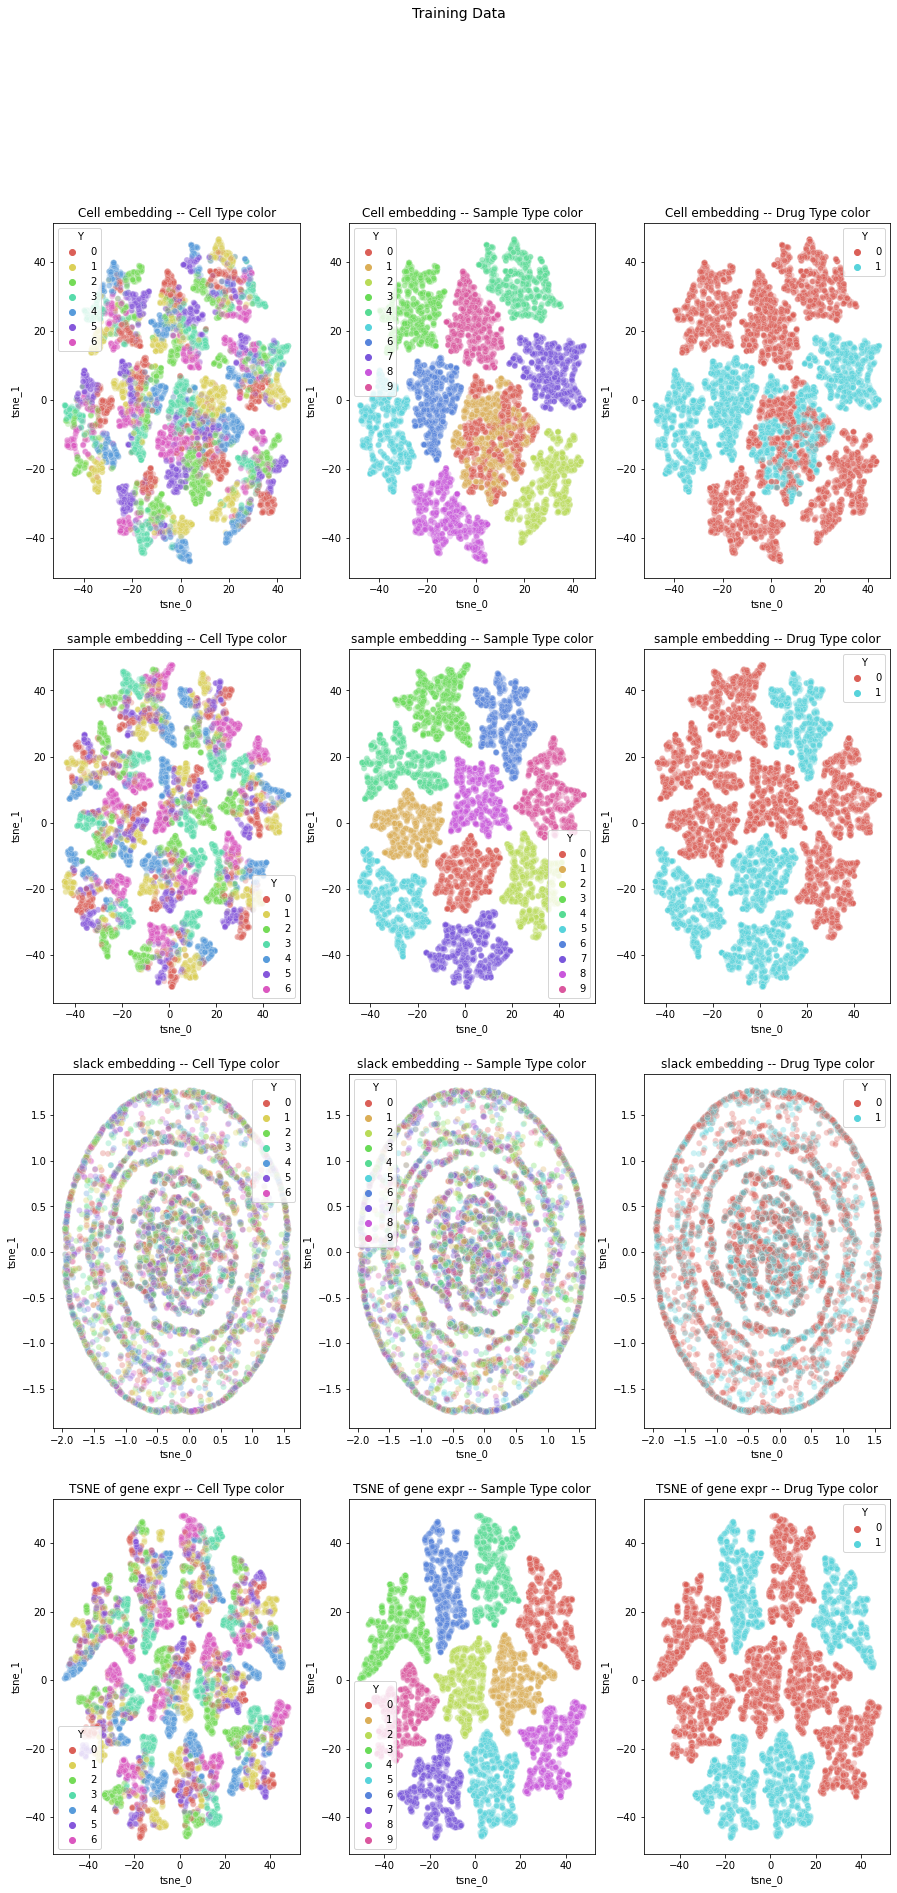

In [107]:
batch_size = 500
# plot proportions on labeled 10x and unlabeled 10x
# this is the training data

X_temp = X_full
X_temp = scale(X_temp, axis=1)

Y_temp = Y_full
Y_temp = np.argmax(Y_temp, axis=1)

label_temp = Label_full
perturb_temp = Drug_full

print(f"Number unique Y: {len(np.unique(Y_temp))}")


_, mu_slack, _, mu_prop, _, prop_outputs, _, mu_rot, _ = encoder.predict(X_temp, batch_size=batch_size)
z_test = mu_prop
encodings= np.asarray(z_test)


fig, axs = plt.subplots(4, 3, figsize=(15,30))

plot_df = get_tsne_for_plotting(np.asarray(mu_prop))
plot_tsne(plot_df, color_vec=Y_temp, ax=axs[0,0], title="Cell embedding -- Cell Type color")
plot_tsne(plot_df, color_vec=label_temp, ax=axs[0,1], title="Cell embedding -- Sample Type color")
plot_tsne(plot_df, color_vec=perturb_temp, ax=axs[0,2], title="Cell embedding -- Drug Type color")

plot_df = get_tsne_for_plotting(np.asarray(mu_rot))
plot_tsne(plot_df, color_vec=Y_temp, ax=axs[1,0], title="sample embedding -- Cell Type color")
plot_tsne(plot_df, color_vec=label_temp, ax=axs[1,1], title="sample embedding -- Sample Type color")
plot_tsne(plot_df, color_vec=perturb_temp, ax=axs[1,2], title="sample embedding -- Drug Type color")

plot_df = get_tsne_for_plotting(np.asarray(mu_slack))
plot_tsne(plot_df, color_vec=Y_temp, ax=axs[2,0], title="slack embedding -- Cell Type color")
plot_tsne(plot_df, color_vec=label_temp, ax=axs[2,1], title="slack embedding -- Sample Type color")
plot_tsne(plot_df, color_vec=perturb_temp, ax=axs[2,2], title="slack embedding -- Drug Type color")

plot_df = get_tsne_for_plotting(np.asarray(X_temp))
plot_tsne(plot_df, color_vec=Y_temp, ax=axs[3,0], title="TSNE of gene expr -- Cell Type color")
plot_tsne(plot_df, color_vec=label_temp, ax=axs[3,1], title="TSNE of gene expr -- Sample Type color")
plot_tsne(plot_df, color_vec=perturb_temp, ax=axs[3,2], title="TSNE of gene expr -- Drug Type color")



fig.suptitle("Training Data", fontsize=14)

fig.show()
